# **----- Import Libraries -----**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib
import html
import ast
import string
import pythainlp

from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords

from gensim.models import LdaModel  # LDA
from gensim.corpora.dictionary import Dictionary  # for count words and create dictionary

# **----- Load Data from Pantip -----**

In [2]:
df_pantip_posts_suicide_labeled = pd.read_excel('../output - final/df_pantip_posts_suicide_labeled.xlsx')

# **----- Prep Data from Pantip -----**

## Prep Data for Classification Modeling

In [3]:
# check dataframe column and data type
print(df_pantip_posts_suicide_labeled.columns)
print(df_pantip_posts_suicide_labeled.dtypes)

Index(['index', 'title', 'url', 'label', 'tags', 'text', 'profile', 'time'], dtype='object')
index               int64
title              object
url                object
label               int64
tags               object
text               object
profile            object
time       datetime64[ns]
dtype: object


In [4]:
# check dataframe label column value count
df_pantip_posts_suicide_labeled['label'].value_counts()

label
0    22814
1      790
2      488
Name: count, dtype: int64

In [5]:
# create the new column in the dataframe called "sub_label" which transform value from the "label" column with following rule:
# value 0 = 0
# value 1 = 11
# value 2 = 12

# Mapping values from the 'label' column to new values for the 'sub_label' column
label_mapping1 = {0: 0, 1: 11, 2: 12}

# Creating the new column 'sub_label' with transformed values
df_pantip_posts_suicide_labeled['sub_label'] = df_pantip_posts_suicide_labeled['label'].map(label_mapping1)

# Display the DataFrame
print(df_pantip_posts_suicide_labeled['sub_label'].value_counts())


sub_label
0     22814
11      790
12      488
Name: count, dtype: int64


In [6]:
# transform the current column 'label with following rules 
# 0 to 0 
# 1 to 1 
# 2 to 1


# Mapping old values from the 'label' column to new values for the 'label' column
label_mapping2 = {0: 0, 1: 1, 2: 1}

# Creating the new column 'sub_label' with transformed values
df_pantip_posts_suicide_labeled['label'] = df_pantip_posts_suicide_labeled['label'].map(label_mapping2)

# Display the DataFrame
print(df_pantip_posts_suicide_labeled['label'].value_counts())

label
0    22814
1     1278
Name: count, dtype: int64


In [7]:
# recheck dataframe column and data type
print(df_pantip_posts_suicide_labeled.columns)
print(df_pantip_posts_suicide_labeled.dtypes)

Index(['index', 'title', 'url', 'label', 'tags', 'text', 'profile', 'time',
       'sub_label'],
      dtype='object')
index                 int64
title                object
url                  object
label                 int64
tags                 object
text                 object
profile              object
time         datetime64[ns]
sub_label             int64
dtype: object


In [8]:
# create the column which combine title and text column 
df_pantip_posts_suicide_labeled ['all_text'] = df_pantip_posts_suicide_labeled ['title'] + " " + df_pantip_posts_suicide_labeled ['text']

In [9]:
# recheck dataframe column and data type
print(df_pantip_posts_suicide_labeled.columns)
print(df_pantip_posts_suicide_labeled.dtypes)

Index(['index', 'title', 'url', 'label', 'tags', 'text', 'profile', 'time',
       'sub_label', 'all_text'],
      dtype='object')
index                 int64
title                object
url                  object
label                 int64
tags                 object
text                 object
profile              object
time         datetime64[ns]
sub_label             int64
all_text             object
dtype: object


In [10]:
# check NaN 
df_pantip_posts_suicide_labeled.isnull().sum()

index          0
title          0
url            0
label          0
tags           0
text         258
profile        0
time           0
sub_label      0
all_text     258
dtype: int64

In [11]:
# drop NaN
df_pantip_posts_suicide_labeled.dropna(inplace=True)

In [12]:
# recheck NaN
df_pantip_posts_suicide_labeled.isnull().sum()

index        0
title        0
url          0
label        0
tags         0
text         0
profile      0
time         0
sub_label    0
all_text     0
dtype: int64

In [13]:
def integrated_preprocess_tokenize(text):
    # Check if text is not a string
    if not isinstance(text, str):
        return []

    ### Preprocessing ###
    text = html.unescape(urllib.parse.unquote(text))  # Unicode and URL decoding
    text = re.sub(r'https?.+?(?:\s|$)', '', text)  # Remove URLs
    text = re.sub(r'[""„\"]', '', text)  # Remove double quotations
    text = re.sub(r'[''′′′′`\']', '', text)  # Remove single quotations
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text)  # Shrink whitespaces
    text = re.sub(r'[\r\u200b\ufeff]+', '', text)  # Remove non-breaking space
    text = re.sub(r'เเ', 'แ', text)  # Correct common misspelling
    text = re.sub(r'(า)า+|(ย)ย+|(ๆ)ๆ+|(ะ)ะ+', r'\1', text)
    text = re.sub(r'ํา','ำ', text)  # Correct character combination
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text)  # Adjust tone marks

    ### Tokenization ###
    tokens = word_tokenize(text, keep_whitespace=False)

    ### Remove Stopwords and Single Thai Alphabets ###
    stopwords = thai_stopwords()
    tokens = [token for token in tokens if token 
              not in stopwords 
              and re.match(r'[A-zก-ไ][A-zก-๙\.]*', token)
              ]

    return tokens

# Applying the integrated function to the DataFrame
df_pantip_posts_suicide_labeled['tokenized_text'] = df_pantip_posts_suicide_labeled['all_text'].apply(integrated_preprocess_tokenize)

# Display the new 'tokenized_text' column
print(df_pantip_posts_suicide_labeled['tokenized_text'])

0        [จบชีวิต, ตัวเอง, ชีวิต, เหมือน, ตายทั้งเป็น, ...
1        [ความคิด, ตอนนี้, รู้สึก, เบื่อ, ชอบ, ชอบแล้ว,...
2        [วิธี, หลุดพ้น, คน, รัก, เรื่อง, คบ, ปี, ตอนนี...
3        [อาการ, แบบนี้, เข้าข่าย, โรค, ซึมเศร้า, หัว, ...
4        [รู้, เป็นโรค, ซึมเศร้า, อาการ, รู้คิด, อาการ,...
                               ...                        
24087    [เครียด, กิน, เครียด, กิน, กินไม่ลง, จิงๆ, ทั้...
24088    [ซึมเศร้า, รู้สึก, ตัวเอง, ล้มเหลว, เรื่อง, กา...
24089    [ม., เทอม, ย้ายที่, เรียน, ไหม, สวัสดี, ค่า, ห...
24090    [อายุ, มากขึ้น, ความสุข, ชีวิต, น้อยลง, อายุ, ...
24091    [อยากรู้, คัว, ค่าย, คน, เป็นโรค, ซึมเศร้า, ร้...
Name: tokenized_text, Length: 23834, dtype: object


In [14]:
# # List of strings to remove
strings_to_remove = [
    "แก้ไขข้อความเมื่อ", "คลิกเพื่อดูข้อความที่ซ่อนไว้",
    "ใส่ข้อความ", "จขกท", "เจ้าของกระทู้", "กระทู้",
    "[Spoil]", "[code]", "[/code]", 
    "เเต่", "เค้า", "ปี", "ตอนนี้", "นะคะ", "กิน", "แบบนี้", "เวลา", "ไหม", "คน", "ดี",
    "เเล้ว", "หนู", "เดือน", "ตอนนั้น", "นะครับ", "ทำ", "แบบนั้น", "เมื่อไร", "อาการ", "ไม่ดี",
    "เพราะ", "ผม", "วัน", "คะ", "รู้สึก", "ตอนไหน", "เรื่อง",
    "เมือ", "คุณ", "สัปดาห์", "ครับ", "ถาม", "ไหน",
    "เหมือน", "เธอ", "อาทิตย์", "ชอบ", "อะไร",
    "มัน", "โดน", "รู้", "มึง", "กู", "เรา", "ชั้น", "ฉัน", "เย", "วัส", 'แล้', 'วจะ', "ตอน", "เจอ", "ที่จะ"
]

def preprocess_and_clean_text2(tokens:list):
    return [token for token in tokens if token not in strings_to_remove]

# Apply the function to the 'all_text' column
df_pantip_posts_suicide_labeled['tokenized_text'] = df_pantip_posts_suicide_labeled['tokenized_text'].apply(preprocess_and_clean_text2)
# Display the new 'tokenized_text' column
df_pantip_posts_suicide_labeled['tokenized_text']  

0        [จบชีวิต, ตัวเอง, ชีวิต, ตายทั้งเป็น, โลก, กา,...
1        [ความคิด, เบื่อ, ชอบแล้ว, คนเดียว, ออกห่าง, เด...
2        [วิธี, หลุดพ้น, รัก, คบ, รัก, ใข้, ชีวิต, คบ, ...
3        [เข้าข่าย, โรค, ซึมเศร้า, หัว, เกริ่น, เรียน, ...
4        [เป็นโรค, ซึมเศร้า, รู้คิด, ร้องไห้, ครอบครัว,...
                               ...                        
24087       [เครียด, เครียด, กินไม่ลง, จิงๆ, ทั้งวัน, หิว]
24088    [ซึมเศร้า, ตัวเอง, ล้มเหลว, การทำงาน, ทำงาน, บ...
24089    [ม., เทอม, ย้ายที่, เรียน, สวัสดี, ค่า, ชื่อ, ...
24090    [อายุ, มากขึ้น, ความสุข, ชีวิต, น้อยลง, อายุ, ...
24091    [อยากรู้, คัว, ค่าย, เป็นโรค, ซึมเศร้า, รู้, ส...
Name: tokenized_text, Length: 23834, dtype: object

In [15]:
# Convert the 'time' column to datetime
df_pantip_posts_suicide_labeled['time'] = pd.to_datetime(df_pantip_posts_suicide_labeled['time'])

# Extract the time column into day of week, day of month, month of year, and year
df_pantip_posts_suicide_labeled['day_week'] = df_pantip_posts_suicide_labeled['time'].dt.day_name()
df_pantip_posts_suicide_labeled['day_month'] = df_pantip_posts_suicide_labeled['time'].dt.day
df_pantip_posts_suicide_labeled['month_year'] = df_pantip_posts_suicide_labeled['time'].dt.month_name()
df_pantip_posts_suicide_labeled['year'] = df_pantip_posts_suicide_labeled['time'].dt.year

In [16]:
# Extract the time column into time of day

# Converting the 'time' column to datetime
df_pantip_posts_suicide_labeled['time'] = pd.to_datetime(df_pantip_posts_suicide_labeled['time'])

# Function to categorize time into the specified ranges
def categorize_time(time):
    if time.hour < 3:
        return '0-3'
    elif time.hour < 6:
        return '3-6'
    elif time.hour < 9:
        return '6-9'
    elif time.hour < 12:
        return '9-12'
    elif time.hour < 15:
        return '12-15'
    elif time.hour < 18:
        return '15-18'
    elif time.hour < 21:
        return '18-21'
    else:
        return '21-24'

# Applying the function to create a new column
df_pantip_posts_suicide_labeled['time_day'] = df_pantip_posts_suicide_labeled['time'].apply(lambda x: categorize_time(x))

# show result 
df_pantip_posts_suicide_labeled['time_day'].value_counts()

time_day
21-24    5384
18-21    4945
15-18    3307
12-15    2878
0-3      2729
9-12     2560
6-9      1149
3-6       882
Name: count, dtype: int64

In [17]:
# create the title length column, text length column, title emoji check column, text emoji check column 

# Function to detect emojis
def contains_emoji(s):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(s))

# Creating the columns
df_pantip_posts_suicide_labeled['title_len'] = df_pantip_posts_suicide_labeled['title'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df_pantip_posts_suicide_labeled['text_len'] = df_pantip_posts_suicide_labeled['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df_pantip_posts_suicide_labeled['title_emoji'] = df_pantip_posts_suicide_labeled['title'].apply(lambda x: 1 if isinstance(x, str) and contains_emoji(x) else 0)
df_pantip_posts_suicide_labeled['text_emoji'] = df_pantip_posts_suicide_labeled['text'].apply(lambda x: 1 if isinstance(x, str) and contains_emoji(x) else 0)


In [18]:
#check NaN
df_pantip_posts_suicide_labeled.isnull().sum()

index             0
title             0
url               0
label             0
tags              0
text              0
profile           0
time              0
sub_label         0
all_text          0
tokenized_text    0
day_week          0
day_month         0
month_year        0
year              0
time_day          0
title_len         0
text_len          0
title_emoji       0
text_emoji        0
dtype: int64

## Save Data to CSV for Classification Modeling

In [19]:
# check newly created columns and categorize features into group to use later 
print(df_pantip_posts_suicide_labeled.columns)

Index(['index', 'title', 'url', 'label', 'tags', 'text', 'profile', 'time',
       'sub_label', 'all_text', 'tokenized_text', 'day_week', 'day_month',
       'month_year', 'year', 'time_day', 'title_len', 'text_len',
       'title_emoji', 'text_emoji'],
      dtype='object')


In [20]:
# save the dataframe df_pantip_posts_suicide_labeled to csv under the name df_pantip_posts_suicide_labeled_processed.csv
df_pantip_posts_suicide_labeled.to_csv('../output - final/df_pantip_posts_suicide_labeled_processed.csv')

## Prep Data for EDA & Toptical Modeling

In [22]:
# Extract the tag column in the one hot encoding columns

# Function to parse the string representation of a list
def parse_tags(tag_str):
    return ast.literal_eval(tag_str)

# Extract and flatten all tags
df_pantip_posts_suicide_labeled['parsed_tags'] = df_pantip_posts_suicide_labeled['tags'].apply(parse_tags)
all_tags = set(tag for sublist in df_pantip_posts_suicide_labeled['parsed_tags'] for tag in sublist)

# Create one-hot encoding for each tag
for tag in all_tags:
    df_pantip_posts_suicide_labeled[tag] = df_pantip_posts_suicide_labeled['parsed_tags'].apply(lambda tags: 1 if tag in tags else 0)

# Display the first 5 rows of the DataFrame for one-hot encoding
df_pantip_posts_suicide_labeled.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_23188\2833341687.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pantip_posts_suicide_labeled[tag] = df_pantip_posts_suicide_labeled['parsed_tags'].apply(lambda tags: 1 if tag in tags else 0)
C:\Users\HP\AppData\Local\Temp\ipykernel_23188\2833341687.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pantip_posts_suicide_labeled[tag] = df_pantip_posts_suicide_labeled['parsed_tags'].apply(lambda tags: 1 if tag in tags else 0)
C:\Users\HP\AppData\Local\Temp\ipykernel_23188\28333

,index,title,url,label,tags,text,profile,time,sub_label,all_text,...,คณิตศาสตร์,วรุฒ วรธรรม (โอ),ปลายจวัก (ละคร),ภาพยนตร์แฟนตาซี,รัก/สาม/เศร้า (ภาพยนตร์),สิว,เกมออนไลน์,การทำงานออนไลน์,กวดวิชา,ถนนสุขสวัสดิ์
0,0,อยากจบชีวิตตัวเอง เพราะชีวิตเหมือนตายทั้งเป็น,https://pantip.com/topic/42367932,1,"['ปัญหาชีวิต', 'สุขภาพจิต', 'โรคซึมเศร้า']",ผิดไหม? ถ้าเราอยากจากโลกนี้ไปตลอดกาล...\n\nขอโ...,https://pantip.com/profile/7860906,2023-11-27 13:47:44,11,อยากจบชีวิตตัวเอง เพราะชีวิตเหมือนตายทั้งเป็น ...,...,0,0,0,0,0,0,0,0,0,0
1,1,ความคิด,https://pantip.com/topic/42367590,0,"['โรคย้ำคิดย้ำทำ', 'สุขภาพจิต', 'โรคซึมเศร้า']",ตอนนี้รู้สึกเบื่อจากที่เคยชอบก็ไม่ชอบแล้ว รู้ส...,https://pantip.com/profile/7860635,2023-11-27 10:36:11,0,ความคิด ตอนนี้รู้สึกเบื่อจากที่เคยชอบก็ไม่ชอบแ...,...,0,0,0,0,0,0,0,0,0,0
2,2,ขอวิธีหลุดพ้นจากคนที่ไม่ได้รัก,https://pantip.com/topic/42367222,0,"['โรคซึมเศร้า', 'ศาลาคนเศร้า']",เรื่องคือ เราคบกับเขาได้2-3ปีเเล้วตอนนี้ เรารั...,https://pantip.com/profile/7860394,2023-11-27 03:43:29,0,ขอวิธีหลุดพ้นจากคนที่ไม่ได้รัก เรื่องคือ เราคบ...,...,0,0,0,0,0,0,0,0,0,0
3,3,อาการแบบนี้เข้าข่ายโรคซึมเศร้ามั้ยครับ,https://pantip.com/topic/42367045,0,"['โรคซึมเศร้า', 'โรคย้ำคิดย้ำทำ', 'สุขภาพจิต',...",ตามหัวกระทู้เลยครับ\n\n\n\nขอเกริ่นก่อนว่าตอนน...,https://pantip.com/profile/7860223,2023-11-27 00:09:00,0,อาการแบบนี้เข้าข่ายโรคซึมเศร้ามั้ยครับ ตามหัวก...,...,0,0,0,0,0,0,0,0,0,0
4,4,เราไม่รู้ว่าเราเป็นโรคซึมเศร้ามั้ย,https://pantip.com/topic/42366704,0,['โรคซึมเศร้า'],แต่อาการเราคล้ายมากไม่รู้คิดเองไปหรือเปล่า อาก...,https://pantip.com/profile/7859934,2023-11-26 20:41:24,0,เราไม่รู้ว่าเราเป็นโรคซึมเศร้ามั้ย แต่อาการเรา...,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Counting number of tags
print(len(all_tags))

# Summing up the occurrences of each tag and sorting them
tag_sums = df_pantip_posts_suicide_labeled[list(all_tags)].sum().sort_values(ascending=False)
tag_sums.head()

1040


โรคซึมเศร้า      23834
สุขภาพจิต        15237
ปัญหาชีวิต       10068
ปัญหาครอบครัว     3715
ปัญหาวัยรุ่น      3677
dtype: int64

# **----- Do EDA & Visualization -----**

## Target label analysis

### 0 = no suicide ideation vs 1 = suicide ideation

In [24]:
# check % frequency of target label suicide ideation vs no suicidie ideation
print(df_pantip_posts_suicide_labeled['label'].value_counts(normalize=True))
print(df_pantip_posts_suicide_labeled['sub_label'].value_counts(normalize=True))

label
0    0.947092
1    0.052908
Name: proportion, dtype: float64
sub_label
0     0.947092
11    0.032684
12    0.020223
Name: proportion, dtype: float64


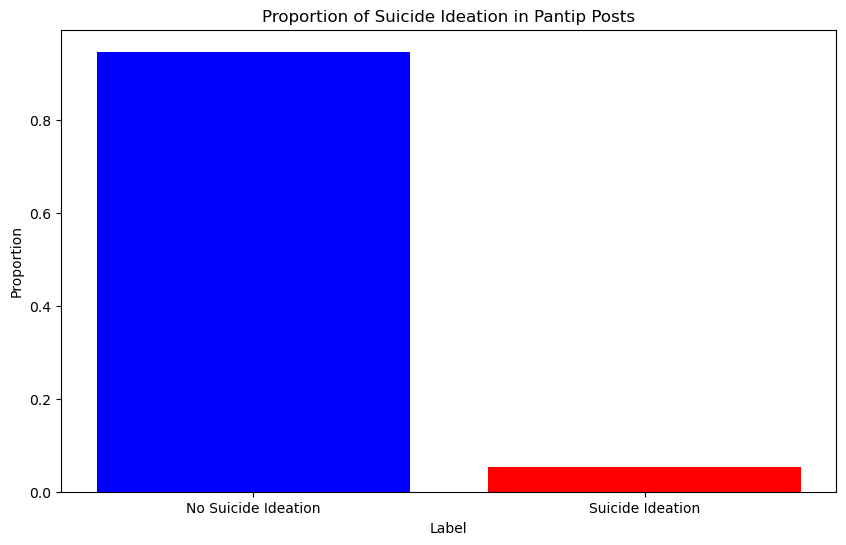

In [25]:
# create bar chart for label column; 0 = no suicide ideation and 1 = suicide ideation
# Data for the bar chart
labels = ['No Suicide Ideation', 'Suicide Ideation']
proportions = [0.947092, 0.052908]

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, proportions, color=['blue', 'red'])
plt.title('Proportion of Suicide Ideation in Pantip Posts')
plt.ylabel('Proportion')
plt.xlabel('Label')
plt.show()

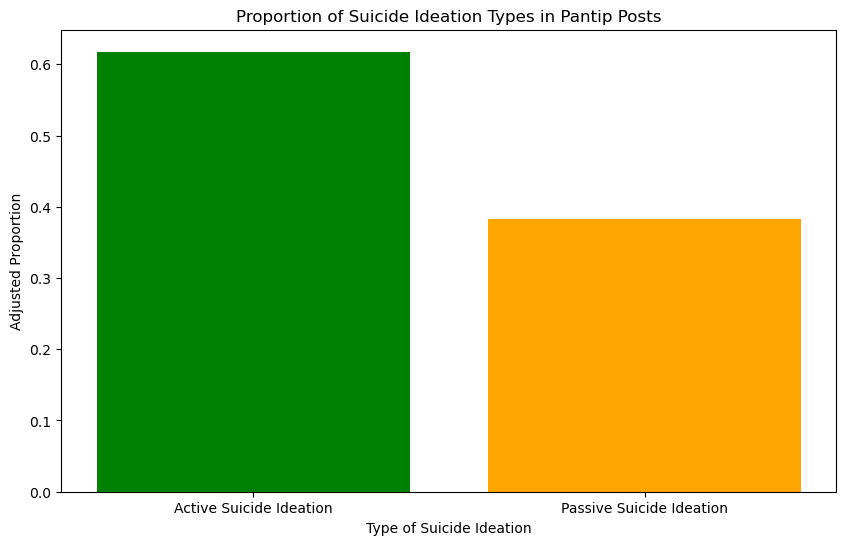

In [26]:
# Assuming label 11 and label 12 together make up 100% of the dataset
# Calculating the new proportions
proportion_11 = 0.032684
proportion_12 = 0.020223
total = proportion_11 + proportion_12

# Calculating the adjusted proportions
adjusted_proportion_11 = proportion_11 / total
adjusted_proportion_12 = proportion_12 / total

# Creating the bar chart
labels = ['Active Suicide Ideation', 'Passive Suicide Ideation']
adjusted_proportions = [adjusted_proportion_11, adjusted_proportion_12]

plt.figure(figsize=(10, 6))
plt.bar(labels, adjusted_proportions, color=['green', 'orange'])
plt.title('Proportion of Suicide Ideation Types in Pantip Posts')
plt.ylabel('Adjusted Proportion')
plt.xlabel('Type of Suicide Ideation')
plt.show()

## Time feature analysis

### Day of week

In [90]:
df_pantip_posts_suicide_labeled['day_week'].value_counts(normalize = True)

day_week
Monday       0.149115
Tuesday      0.145884
Wednesday    0.144038
Sunday       0.143534
Thursday     0.139800
Friday       0.138919
Saturday     0.138709
Name: proportion, dtype: float64

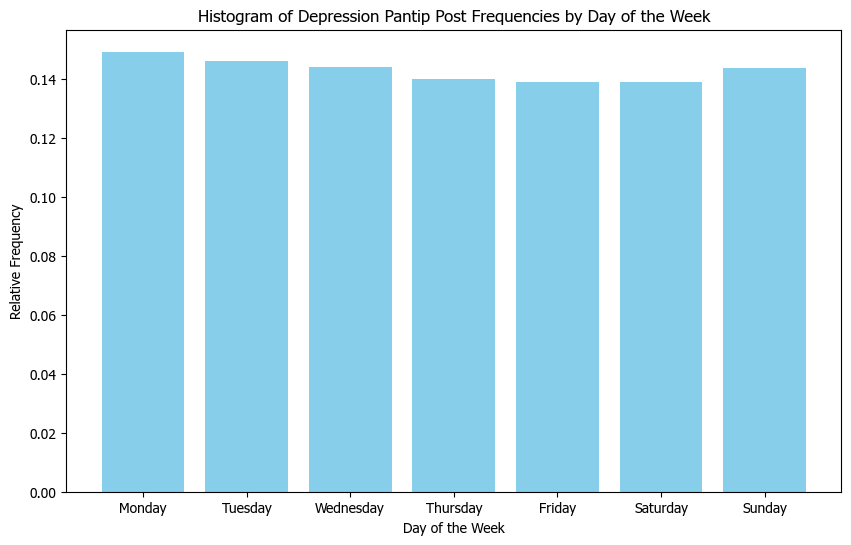

In [91]:
# Extracting value counts and converting to relative frequencies
day_week_counts = df_pantip_posts_suicide_labeled['day_week'].value_counts(normalize=True)

# Creating a DataFrame from the day_week_counts
df_day_week = pd.DataFrame({'Day': day_week_counts.index, 'Frequency': day_week_counts.values})

# Ordering the DataFrame by day of the week
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_day_week['Day'] = pd.Categorical(df_day_week['Day'], categories=order, ordered=True)
df_day_week = df_day_week.sort_values('Day')

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(df_day_week['Day'], df_day_week['Frequency'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Depression Pantip Post Frequencies by Day of the Week')
plt.show()

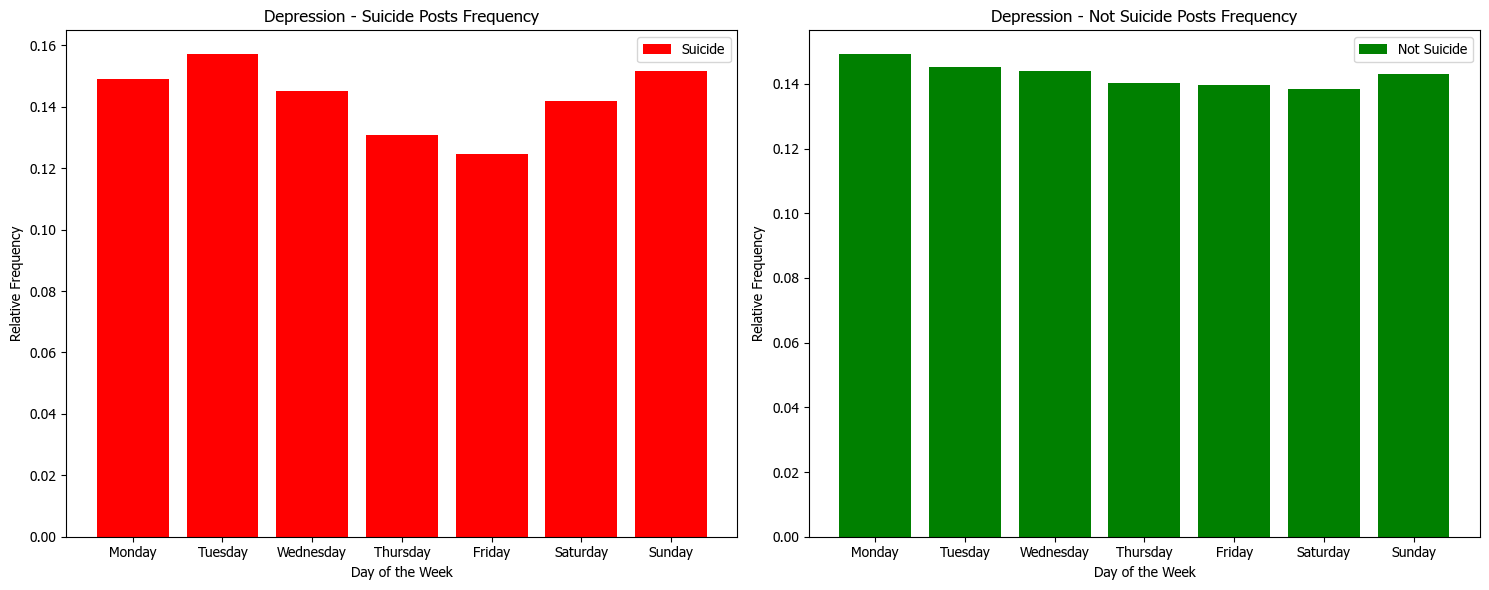

In [93]:
# Separate the data based on the 'label' values
suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]
not_suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies for each label
suicide_counts = suicide_posts['day_week'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['day_week'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'Day': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'Day': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by day of the week
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_suicide['Day'] = pd.Categorical(df_suicide['Day'], categories=order, ordered=True)
df_suicide = df_suicide.sort_values('Day')
df_not_suicide['Day'] = pd.Categorical(df_not_suicide['Day'], categories=order, ordered=True)
df_not_suicide = df_not_suicide.sort_values('Day')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['Day'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Depression - Suicide Posts Frequency')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Relative Frequency')
axes[0].legend()

axes[1].bar(df_not_suicide['Day'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Depression - Not Suicide Posts Frequency')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Relative Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

### Day of month

In [94]:
df_pantip_posts_suicide_labeled['day_month'].value_counts(normalize = True)

day_month
23    0.037384
22    0.035915
25    0.034572
11    0.034195
12    0.034027
10    0.033943
26    0.033943
20    0.033733
21    0.033607
9     0.033272
18    0.033188
19    0.033104
27    0.032936
17    0.032936
6     0.032894
28    0.032768
14    0.032726
5     0.032517
2     0.032475
16    0.032391
15    0.032307
24    0.032265
7     0.032139
13    0.031971
4     0.030880
3     0.030838
8     0.030629
30    0.030083
29    0.029622
1     0.029412
31    0.017328
Name: proportion, dtype: float64

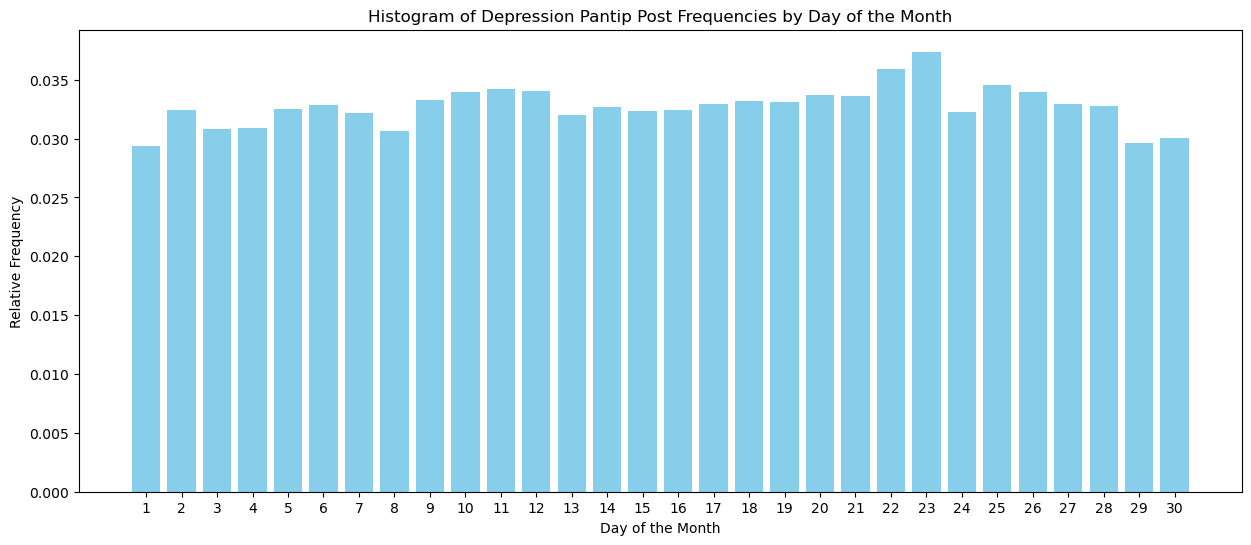

In [24]:
# Extracting value counts and converting to relative frequencies for the 'day_month' column
day_month_counts = df_pantip_posts_suicide_labeled['day_month'].value_counts(normalize=True)

# Creating a DataFrame from the day_month_counts
df_day_month = pd.DataFrame({'Day': day_month_counts.index, 'Frequency': day_month_counts.values})

# Ordering the DataFrame by day of the month
order = list(range(1, 31))  # Days from 1 to 30
df_day_month['Day'] = pd.Categorical(df_day_month['Day'], categories=order, ordered=True)
df_day_month = df_day_month.sort_values('Day')

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_day_month['Day'], df_day_month['Frequency'], color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Depression Pantip Post Frequencies by Day of the Month')
plt.xticks(order)  # To ensure all days are displayed on the x-axis
plt.show()

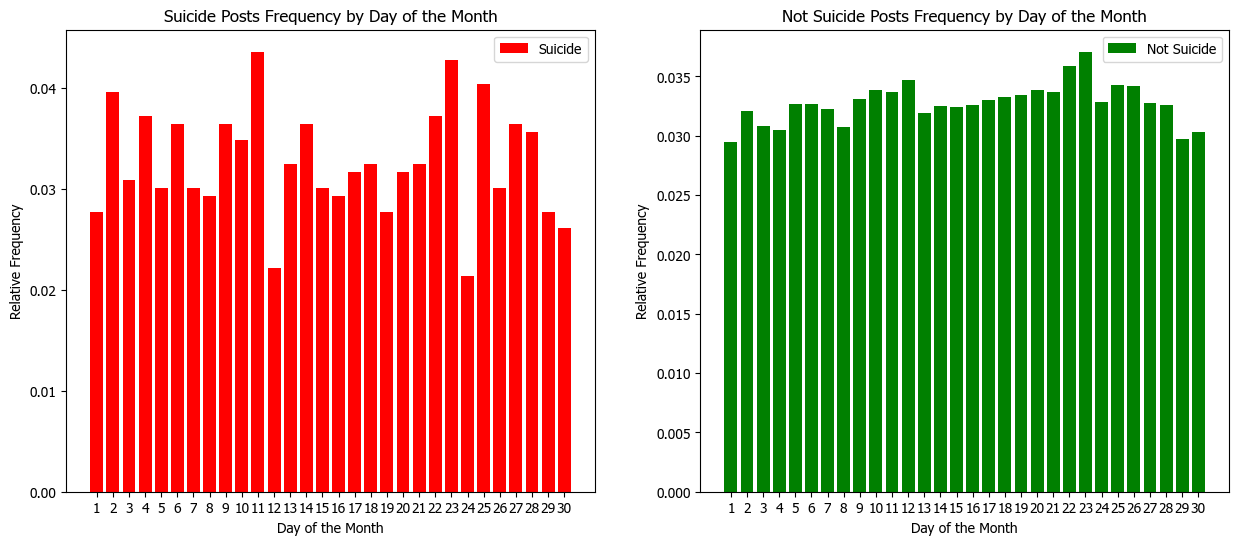

In [95]:
# Separate the data based on the 'label' values
suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]
not_suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies
suicide_counts = suicide_posts['day_month'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['day_month'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'Day': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'Day': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by day of the month
order = list(range(1, 31))  # Days from 1 to 30
df_suicide['Day'] = pd.Categorical(df_suicide['Day'], categories=order, ordered=True)
df_suicide = df_suicide.sort_values('Day')
df_not_suicide['Day'] = pd.Categorical(df_not_suicide['Day'], categories=order, ordered=True)
df_not_suicide = df_not_suicide.sort_values('Day')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['Day'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Suicide Posts Frequency by Day of the Month')
axes[0].set_xlabel('Day of the Month')
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xticks(order)
axes[0].legend()

axes[1].bar(df_not_suicide['Day'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Not Suicide Posts Frequency by Day of the Month')
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xticks(order)
axes[1].legend()

### Month of year

In [96]:
df_pantip_posts_suicide_labeled['month_year'].value_counts(normalize = True)

month_year
October      0.094319
June         0.088319
September    0.087648
July         0.086683
August       0.086557
March        0.086431
May          0.082613
November     0.080138
January      0.079634
April        0.079634
December     0.076823
February     0.071201
Name: proportion, dtype: float64

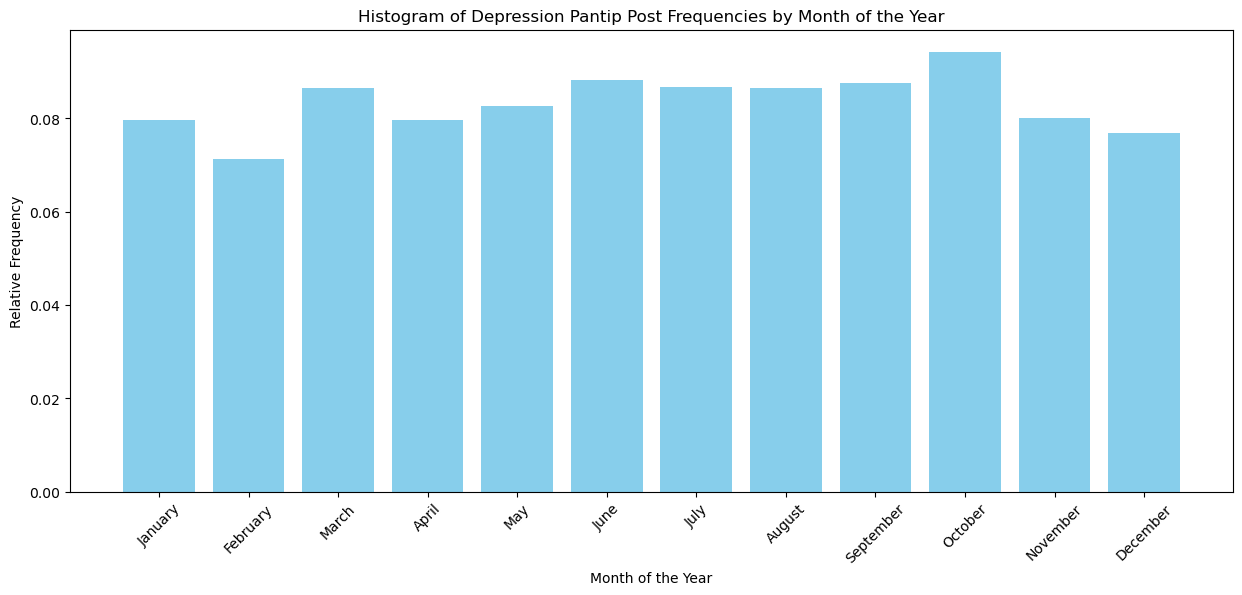

In [27]:
# Extracting value counts and converting to relative frequencies for the 'month_year' column
month_year_counts = df_pantip_posts_suicide_labeled['month_year'].value_counts(normalize=True)

# Creating a DataFrame from the month_year_counts
df_month_year = pd.DataFrame({'Month': month_year_counts.index, 'Frequency': month_year_counts.values})

# Ordering the DataFrame by month
order = ['January', 'February', 'March', 'April', 'May', 'June', 
         'July', 'August', 'September', 'October', 'November', 'December']
df_month_year['Month'] = pd.Categorical(df_month_year['Month'], categories=order, ordered=True)
df_month_year = df_month_year.sort_values('Month')

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_month_year['Month'], df_month_year['Frequency'], color='skyblue')
plt.xlabel('Month of the Year')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Depression Pantip Post Frequencies by Month of the Year')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

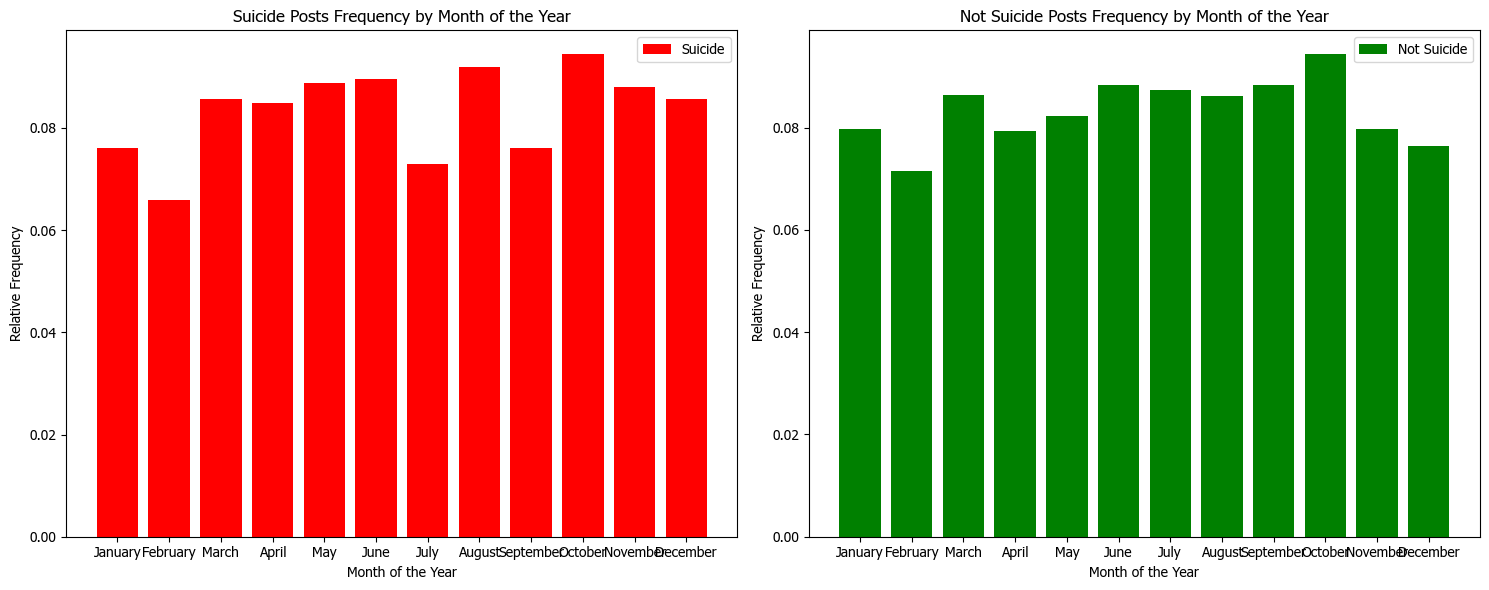

In [97]:
# Separate the data based on the 'label' values
suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]
not_suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies for each label
suicide_counts = suicide_posts['month_year'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['month_year'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'Month': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'Month': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by month of the year
order = ['January', 'February', 'March', 'April', 'May', 'June', 
         'July', 'August', 'September', 'October', 'November', 'December']
df_suicide['Month'] = pd.Categorical(df_suicide['Month'], categories=order, ordered=True)
df_suicide = df_suicide.sort_values('Month')
df_not_suicide['Month'] = pd.Categorical(df_not_suicide['Month'], categories=order, ordered=True)
df_not_suicide = df_not_suicide.sort_values('Month')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['Month'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Suicide Posts Frequency by Month of the Year')
axes[0].set_xlabel('Month of the Year')
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xticks(order)
axes[0].legend()

axes[1].bar(df_not_suicide['Month'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Not Suicide Posts Frequency by Month of the Year')
axes[1].set_xlabel('Month of the Year')
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xticks(order)
axes[1].legend()

plt.tight_layout()
plt.show()

### Time of day

In [98]:
df_pantip_posts_suicide_labeled['time_day'].value_counts(normalize = True)

time_day
21-24    0.225896
18-21    0.207477
15-18    0.138751
12-15    0.120752
0-3      0.114500
9-12     0.107410
6-9      0.048208
3-6      0.037006
Name: proportion, dtype: float64

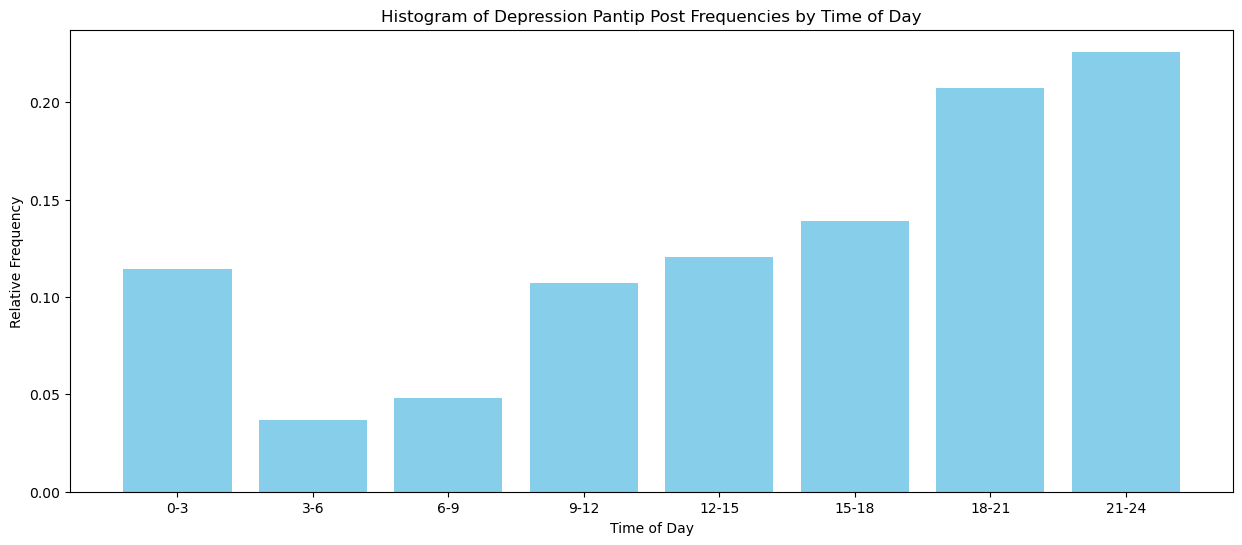

In [30]:
# Extracting value counts and converting to relative frequencies for the 'time_day' column
time_day_counts = df_pantip_posts_suicide_labeled['time_day'].value_counts(normalize=True)

# Creating a DataFrame from the time_day_counts
df_time_day = pd.DataFrame({'TimeRange': time_day_counts.index, 'Frequency': time_day_counts.values})

# Ordering the DataFrame by time ranges
time_order = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
df_time_day['TimeRange'] = pd.Categorical(df_time_day['TimeRange'], categories=time_order, ordered=True)
df_time_day = df_time_day.sort_values('TimeRange')

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_time_day['TimeRange'], df_time_day['Frequency'], color='skyblue')
plt.xlabel('Time of Day')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Depression Pantip Post Frequencies by Time of Day')
plt.xticks(time_order)  # Ensure all time ranges are displayed on the x-axis
plt.show()

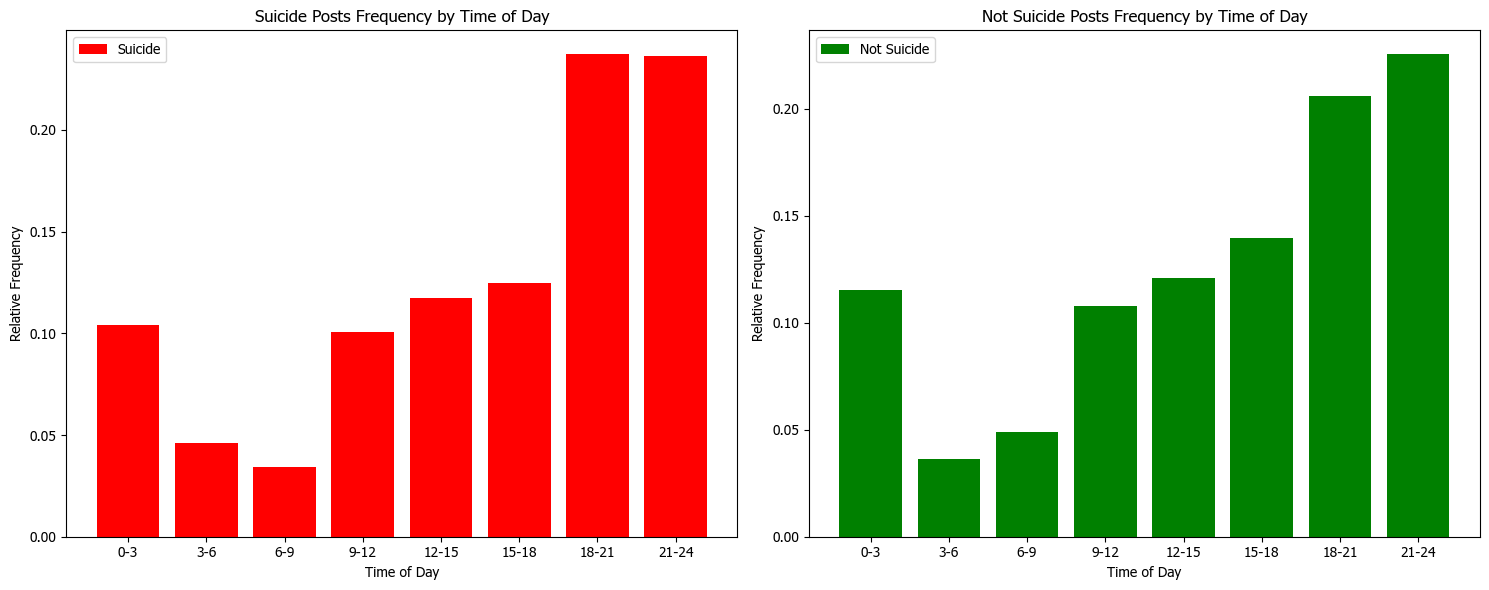

In [99]:
# Separate the data based on the 'label' values
suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]
not_suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies for each label
suicide_counts = suicide_posts['time_day'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['time_day'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'TimeRange': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'TimeRange': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by time of day
time_order = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
df_suicide['TimeRange'] = pd.Categorical(df_suicide['TimeRange'], categories=time_order, ordered=True)
df_suicide = df_suicide.sort_values('TimeRange')
df_not_suicide['TimeRange'] = pd.Categorical(df_not_suicide['TimeRange'], categories=time_order, ordered=True)
df_not_suicide = df_not_suicide.sort_values('TimeRange')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['TimeRange'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Suicide Posts Frequency by Time of Day')
axes[0].set_xlabel('Time of Day')
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xticks(time_order)
axes[0].legend()

axes[1].bar(df_not_suicide['TimeRange'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Not Suicide Posts Frequency by Time of Day')
axes[1].set_xlabel('Time of Day')
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xticks(time_order)
axes[1].legend()

plt.tight_layout()
plt.show()

### Year

In [100]:
df_pantip_posts_suicide_labeled['year'].value_counts(normalize = True)

year
2019    0.189939
2017    0.152010
2020    0.148359
2018    0.132877
2021    0.129017
2022    0.102920
2023    0.083242
2016    0.061635
Name: proportion, dtype: float64

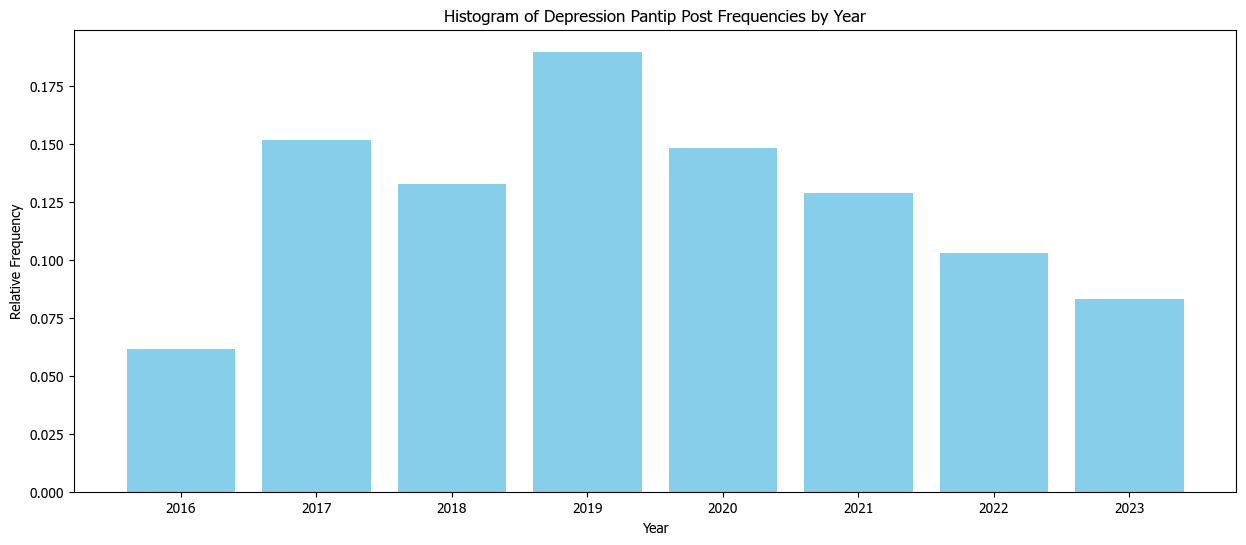

In [101]:

# Extracting value counts and converting to relative frequencies for the 'year' column
year_counts = df_pantip_posts_suicide_labeled['year'].value_counts(normalize=True)

# Creating a DataFrame from the year_counts
df_year = pd.DataFrame({'Year': year_counts.index, 'Frequency': year_counts.values})

# Ordering the DataFrame by year
df_year = df_year.sort_values('Year')

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_year['Year'], df_year['Frequency'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Depression Pantip Post Frequencies by Year')
plt.xticks(df_year['Year'])  # Ensure all years are displayed on the x-axis
plt.show()

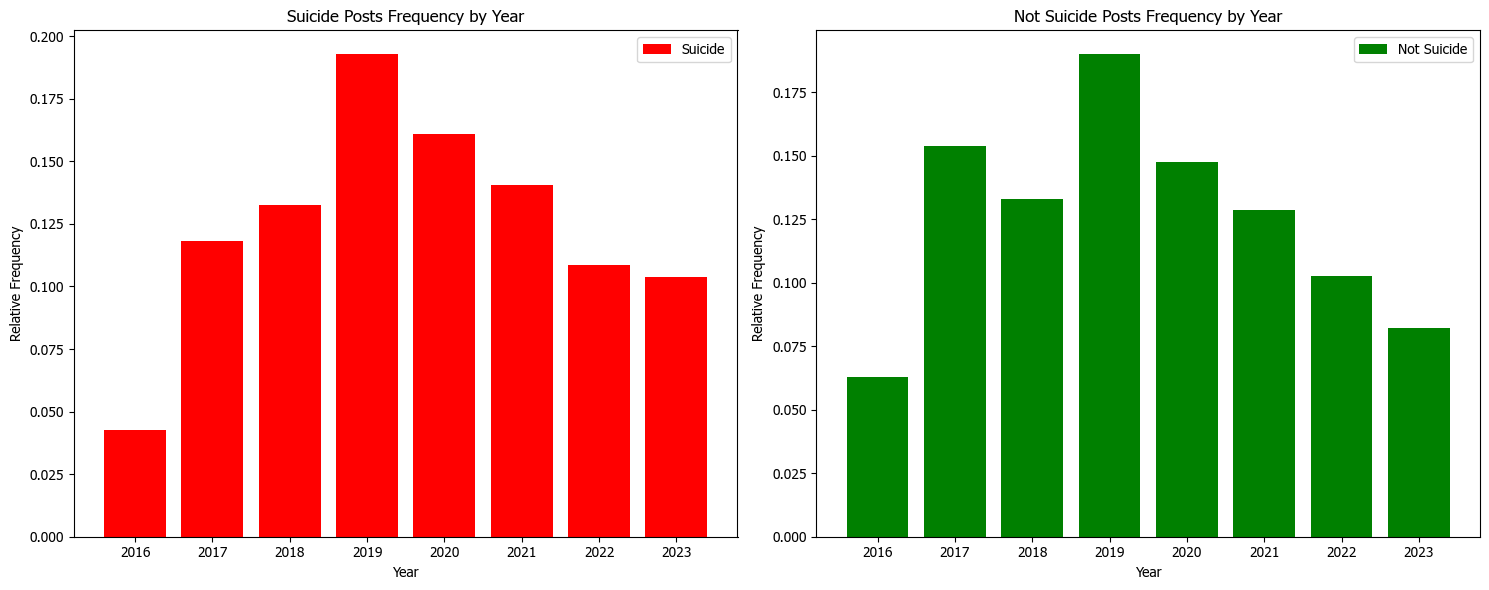

In [102]:
# Separate the data based on the 'label' values
suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]
not_suicide_posts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies for each label
suicide_counts = suicide_posts['year'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['year'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'Year': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'Year': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by year
df_suicide = df_suicide.sort_values('Year')
df_not_suicide = df_not_suicide.sort_values('Year')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['Year'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Suicide Posts Frequency by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Relative Frequency')
axes[0].legend()

axes[1].bar(df_not_suicide['Year'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Not Suicide Posts Frequency by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Relative Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

## Text numeric feature analysis

### Length of title

In [103]:
df_pantip_posts_suicide_labeled['title_len'].value_counts(normalize = True)

title_len
32     0.023748
33     0.023412
35     0.022699
31     0.022447
37     0.022363
         ...   
115    0.000923
112    0.000881
102    0.000839
117    0.000755
4      0.000042
Name: proportion, Length: 117, dtype: float64

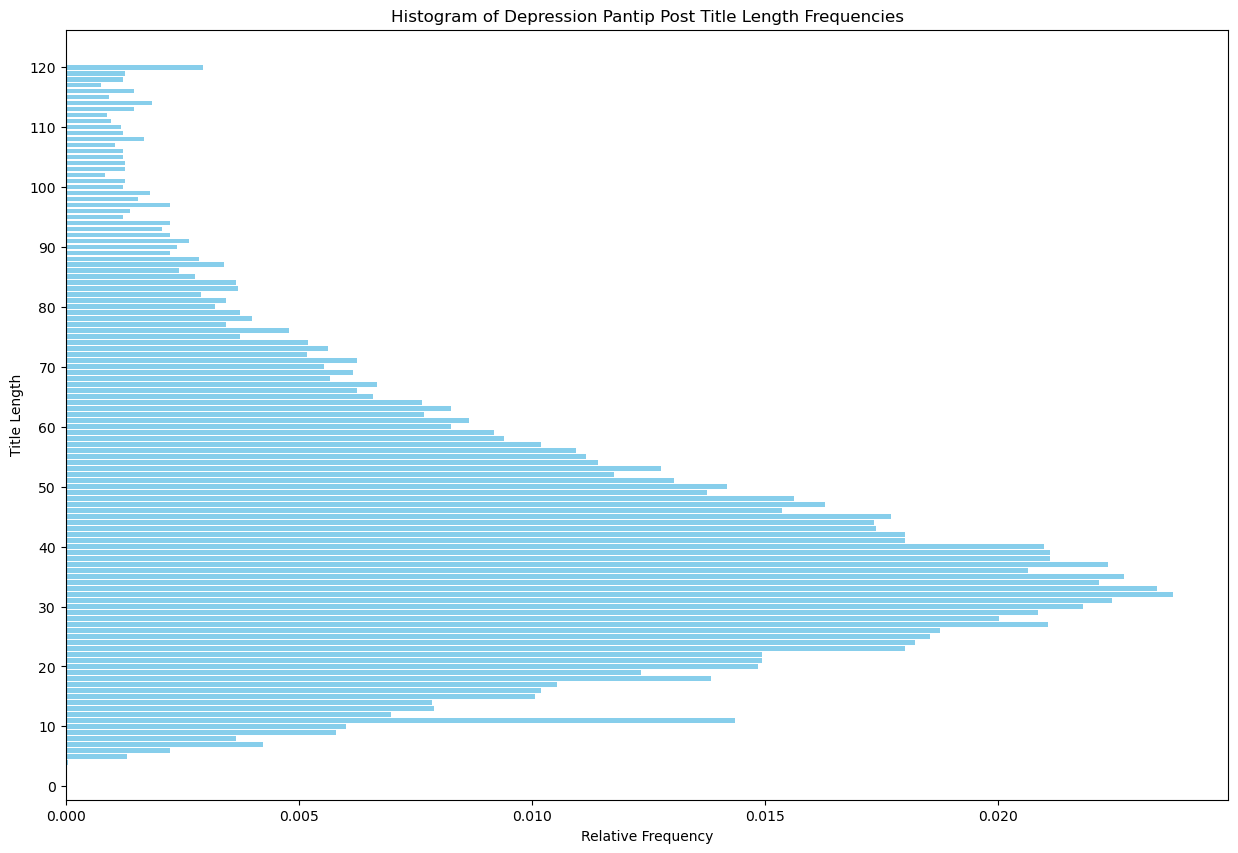

In [36]:
# Extracting value counts and converting to relative frequencies for the 'title_len' column
title_len_counts = df_pantip_posts_suicide_labeled['title_len'].value_counts(normalize=True)

# Creating a DataFrame from the title_len_counts
df_title_len = pd.DataFrame({'Title Length': title_len_counts.index, 'Frequency': title_len_counts.values})

# Ordering the DataFrame by title length from min to max
df_title_len = df_title_len.sort_values('Title Length')

# Plotting the horizontal bar chart
plt.figure(figsize=(15, 10))
plt.barh(df_title_len['Title Length'], df_title_len['Frequency'], color='skyblue')
plt.ylabel('Title Length')
plt.xlabel('Relative Frequency')
plt.title('Histogram of Depression Pantip Post Title Length Frequencies')

# Adjusting y-axis to show ticks only at multiples of 10
plt.yticks(np.arange(0, max(df_title_len['Title Length']) + 10, 10))  # Ticks at every 10 units
plt.xticks(fontsize=10)  # Smaller font for x-axis ticks

plt.show()

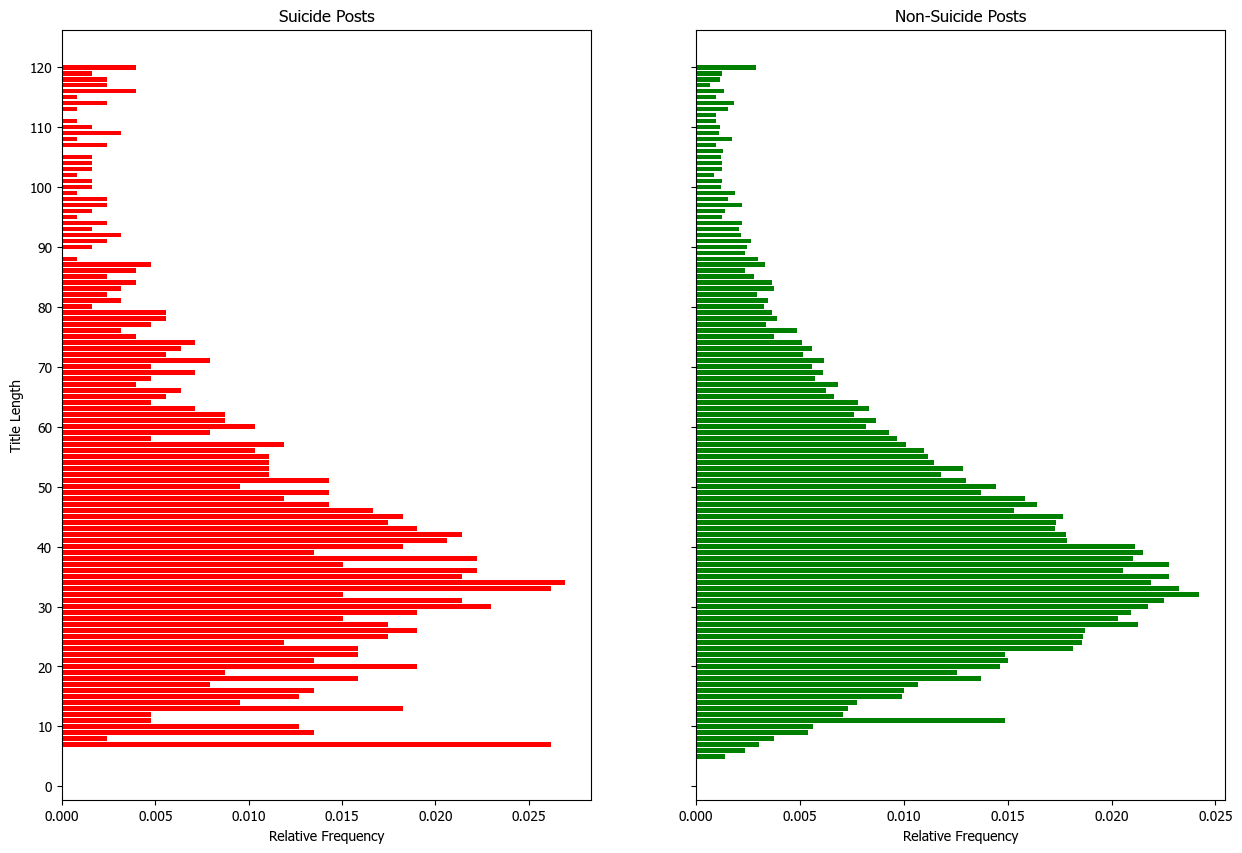

In [104]:
# Extracting value counts for each label
title_len_counts_label_1 = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]['title_len'].value_counts(normalize=True)
title_len_counts_label_0 = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]['title_len'].value_counts(normalize=True)

# Creating DataFrames from the counts
df_title_len_label_1 = pd.DataFrame({'Title Length': title_len_counts_label_1.index, 'Frequency': title_len_counts_label_1.values})
df_title_len_label_0 = pd.DataFrame({'Title Length': title_len_counts_label_0.index, 'Frequency': title_len_counts_label_0.values})

# Sorting the DataFrames
df_title_len_label_1 = df_title_len_label_1.sort_values('Title Length')
df_title_len_label_0 = df_title_len_label_0.sort_values('Title Length')

# Setting up the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True)

# Plotting the chart for label 1 (suicide)
axes[0].barh(df_title_len_label_1['Title Length'], df_title_len_label_1['Frequency'], color='red')
axes[0].set_title('Suicide Posts')
axes[0].set_xlabel('Relative Frequency')
axes[0].set_ylabel('Title Length')
axes[0].tick_params(axis='x', labelsize=10)  # Smaller font for x-axis ticks
axes[0].set_yticks(np.arange(0, max(df_title_len_label_1['Title Length']) + 10, 10))  # Ticks at every 10 units on y-axis

# Plotting the chart for label 0 (not suicide)
axes[1].barh(df_title_len_label_0['Title Length'], df_title_len_label_0['Frequency'], color='green')
axes[1].set_title('Non-Suicide Posts')
axes[1].set_xlabel('Relative Frequency')
axes[1].tick_params(axis='x', labelsize=10)  # Smaller font for x-axis ticks
axes[1].set_yticks(np.arange(0, max(df_title_len_label_0['Title Length']) + 10, 10))  # Ticks at every 10 units on y-axis

plt.show()


In [105]:
print('Depression _ Suicide Ideation')
print(df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]['title_len'].describe())
print('\n')
print('Depression _ Non Suicide Ideation')
print(df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]['title_len'].describe())

Depression _ Suicide Ideation
count    1261.000000
mean       42.563838
std        24.022412
min         7.000000
25%        26.000000
50%        38.000000
75%        54.000000
max       120.000000
Name: title_len, dtype: float64


Depression _ Non Suicide Ideation
count    22573.000000
mean        43.002747
std         22.382227
min          4.000000
25%         27.000000
50%         39.000000
75%         54.000000
max        120.000000
Name: title_len, dtype: float64


### Length of text

In [106]:
df_pantip_posts_suicide_labeled['text_len'].value_counts(normalize = True)

text_len
17      0.031300
47      0.005748
57      0.004951
48      0.004196
46      0.002140
          ...   
6184    0.000042
4383    0.000042
4570    0.000042
2637    0.000042
4371    0.000042
Name: proportion, Length: 3929, dtype: float64

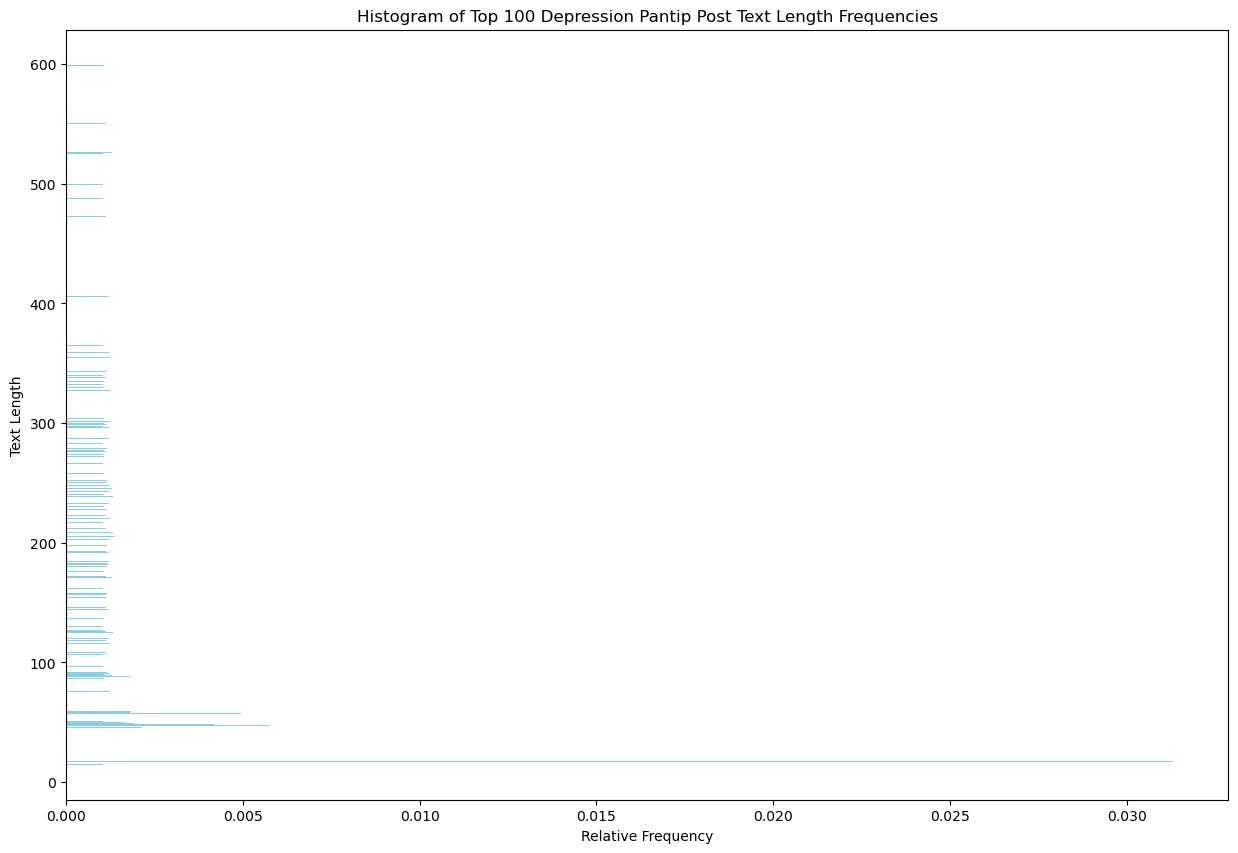

In [40]:
# Extracting value counts and converting to relative frequencies for the 'text_len' column
text_len_counts = df_pantip_posts_suicide_labeled['text_len'].value_counts(normalize=True)

# Creating a DataFrame from the text_len_counts
df_text_len = pd.DataFrame({'Text Length': text_len_counts.index, 'Frequency': text_len_counts.values})

# Sorting the DataFrame by Frequency and selecting the top 100 values
df_text_len = df_text_len.sort_values('Frequency', ascending=False).head(100)

# Re-sorting the selected DataFrame by Text Length
df_text_len = df_text_len.sort_values('Text Length')

# Plotting the horizontal bar chart
plt.figure(figsize=(15, 10))
plt.barh(df_text_len['Text Length'], df_text_len['Frequency'], color='skyblue')
plt.ylabel('Text Length')
plt.xlabel('Relative Frequency')
plt.title('Histogram of Top 100 Depression Pantip Post Text Length Frequencies')
plt.yticks(np.arange(0, max(df_text_len['Text Length']) + 100, 100))  # Adjusting y-axis ticks
plt.xticks(fontsize=10)  # Smaller font for x-axis ticks

plt.show()

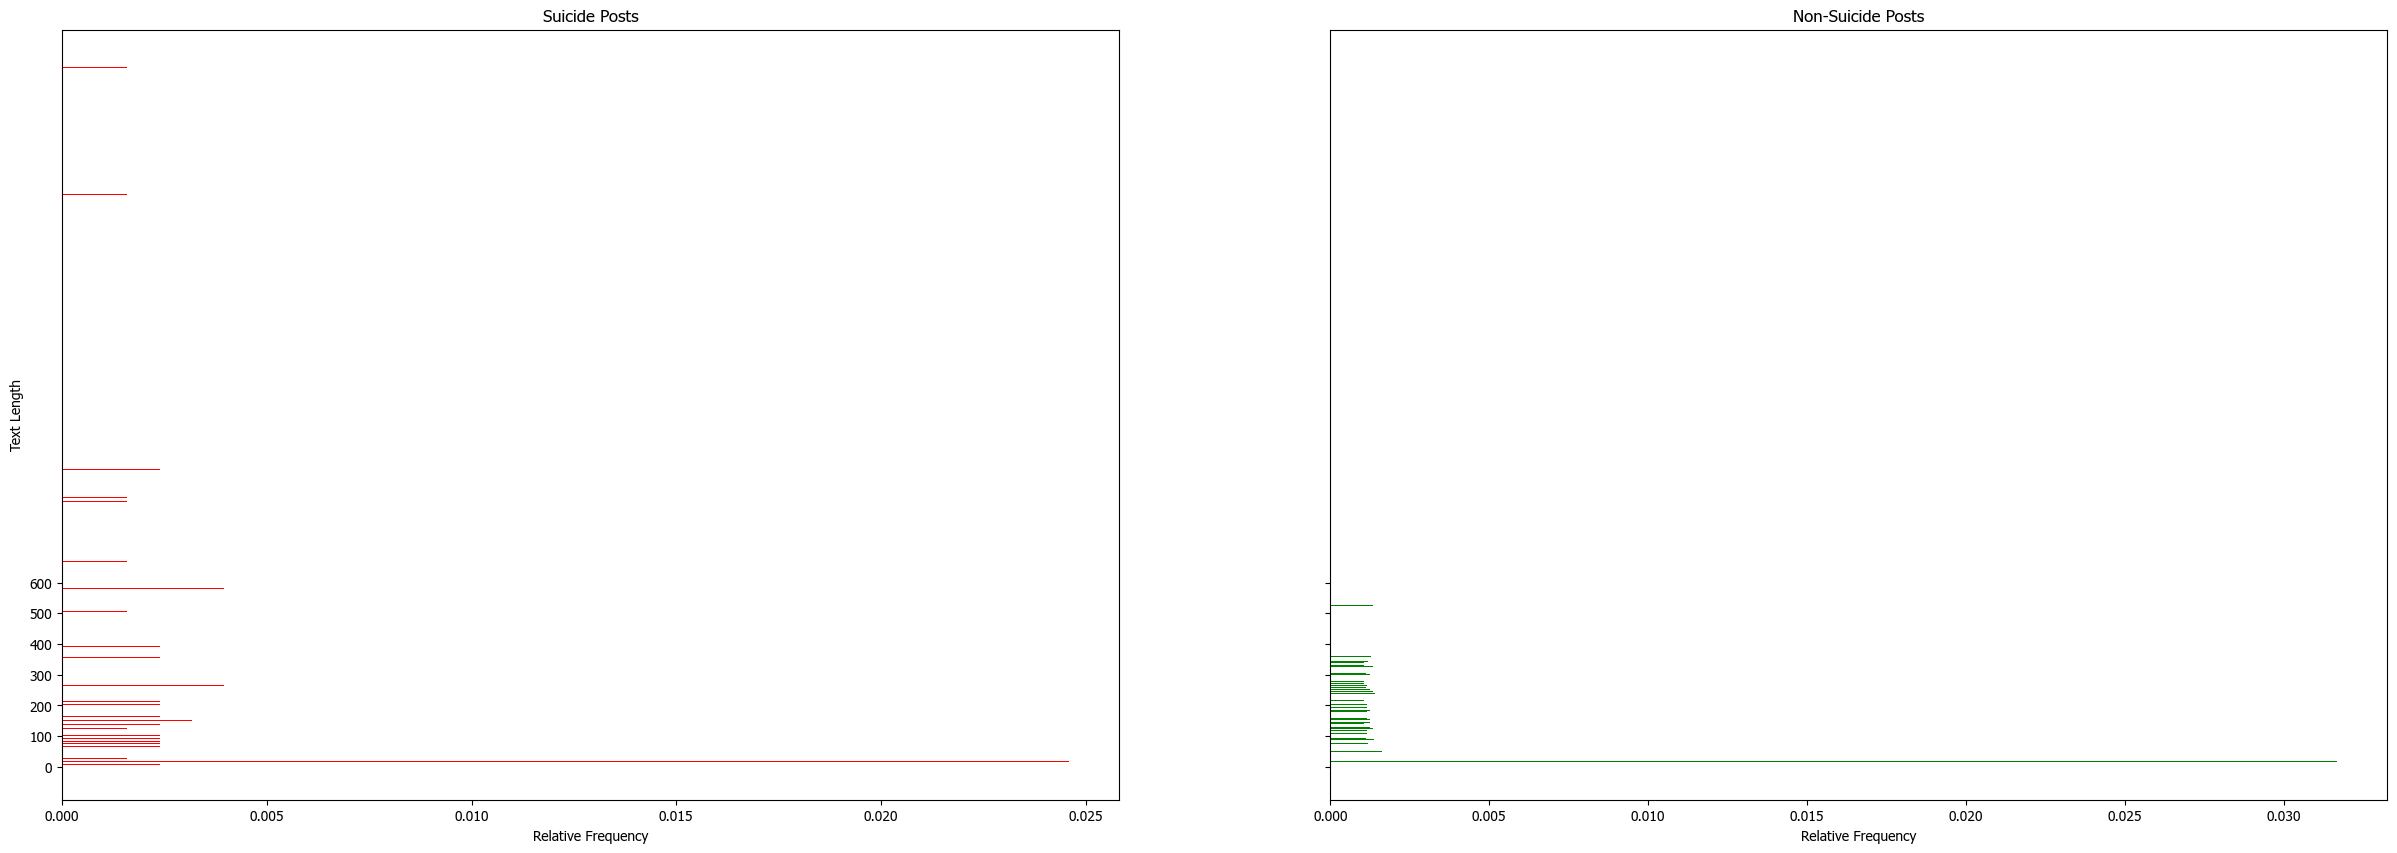

In [107]:
# Extracting value counts for each label and converting to relative frequencies
text_len_counts_label_1 = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]['text_len'].value_counts(normalize=True)
text_len_counts_label_0 = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]['text_len'].value_counts(normalize=True)

# Creating DataFrames from the counts
df_text_len_label_1 = pd.DataFrame({'Text Length': text_len_counts_label_1.index, 'Frequency': text_len_counts_label_1.values})
df_text_len_label_0 = pd.DataFrame({'Text Length': text_len_counts_label_0.index, 'Frequency': text_len_counts_label_0.values})

# Sorting the DataFrames by Frequency and selecting the top 100 values, then re-sorting by Text Length
df_text_len_label_1 = df_text_len_label_1.sort_values('Frequency', ascending=False).head(100).sort_values('Text Length')
df_text_len_label_0 = df_text_len_label_0.sort_values('Frequency', ascending=False).head(100).sort_values('Text Length')

# Setting up the plot
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey=True)

# Plotting the chart for label 1 (suicide)
axes[0].barh(df_text_len_label_1['Text Length'], df_text_len_label_1['Frequency'], color='red')
axes[0].set_title('Suicide Posts')
axes[0].set_xlabel('Relative Frequency')
axes[0].set_ylabel('Text Length')
axes[0].set_yticks(np.arange(0, max(df_text_len_label_1['Text Length']) + 100, 100))  # Adjusting y-axis ticks

# Plotting the chart for label 0 (not suicide)
axes[1].barh(df_text_len_label_0['Text Length'], df_text_len_label_0['Frequency'], color='green')
axes[1].set_title('Non-Suicide Posts')
axes[1].set_xlabel('Relative Frequency')
axes[1].set_yticks(np.arange(0, max(df_text_len_label_0['Text Length']) + 100, 100))  # Adjusting y-axis ticks

plt.show()

In [108]:
print('Depression _ Suicide Ideation')
print(df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]['text_len'].describe())
print('\n')
print('Depression _ Non Suicide Ideation')
print(df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]['text_len'].describe())

Depression _ Suicide Ideation
count     1261.000000
mean       927.459159
std       1244.655789
min          3.000000
25%        215.000000
50%        538.000000
75%       1092.000000
max      10035.000000
Name: text_len, dtype: float64


Depression _ Non Suicide Ideation
count    22573.000000
mean       979.791166
std       1261.444027
min          1.000000
25%        249.000000
50%        569.000000
75%       1199.000000
max      10133.000000
Name: text_len, dtype: float64


## Text category feature analysis 

### Emoji check on title

In [109]:
df_pantip_posts_suicide_labeled['title_emoji'].value_counts(normalize=True)

title_emoji
0    0.988714
1    0.011286
Name: proportion, dtype: float64

In [110]:
print('Depression _ Suicide Ideation')
print(df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]['title_emoji'].value_counts(normalize=True))
print('\n')
print('Depression _ Non Suicide Ideation')
print(df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]['title_emoji'].value_counts(normalize=True))

Depression _ Suicide Ideation
title_emoji
0    0.985726
1    0.014274
Name: proportion, dtype: float64


Depression _ Non Suicide Ideation
title_emoji
0    0.988881
1    0.011119
Name: proportion, dtype: float64


### Emoji check on text 

In [111]:
df_pantip_posts_suicide_labeled['text_emoji'].value_counts(normalize=True)

text_emoji
0    0.906352
1    0.093648
Name: proportion, dtype: float64

In [112]:
print('Depression _ Suicide Ideation')
print(df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]['text_emoji'].value_counts(normalize=True))
print('\n')
print('Depression _ Non Suicide Ideation')
print(df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]['text_emoji'].value_counts(normalize=True))

Depression _ Suicide Ideation
text_emoji
0    0.902458
1    0.097542
Name: proportion, dtype: float64


Depression _ Non Suicide Ideation
text_emoji
0    0.90657
1    0.09343
Name: proportion, dtype: float64


## Tag feature analysis

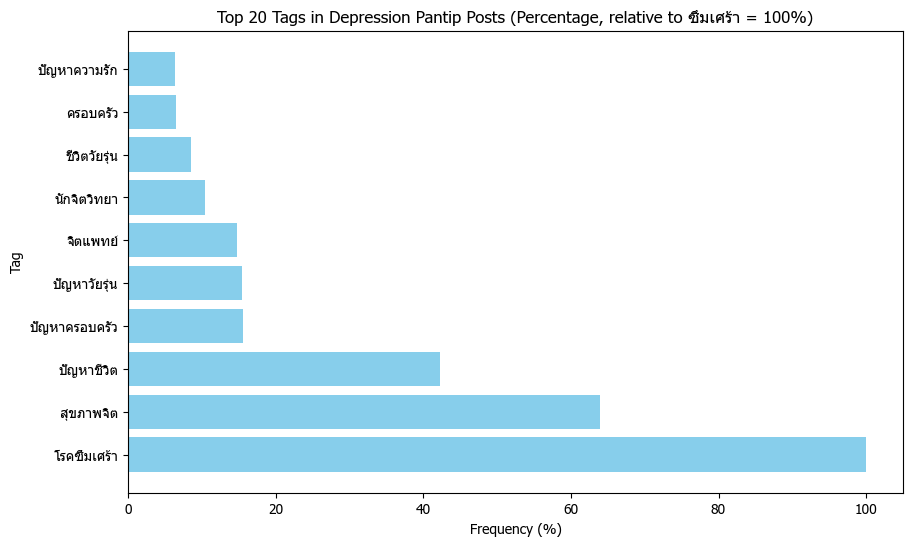

In [34]:
# Normalizing the number to percentages assuming tag "ซึมเศร้า" represents 100%
total_for_depression = tag_sums["โรคซึมเศร้า"]
tag_sums_normalized = tag_sums / total_for_depression * 100

# Creating a DataFrame for the top 20 tags
df_tag_sums = pd.DataFrame({'Tag': tag_sums_normalized.index, 'Frequency (%)': tag_sums_normalized.values})

# Sorting the DataFrame by Frequency
df_tag_sums = df_tag_sums.sort_values('Frequency (%)', ascending=False).head(10)

# Choose a font that supports Thai characters
matplotlib.rc('font', family='Tahoma')

# Plotting the horizontal bar chart for the top 20 tags
plt.figure(figsize=(10, 6))
plt.barh(df_tag_sums['Tag'], df_tag_sums['Frequency (%)'], color='skyblue')
plt.xlabel('Frequency (%)')
plt.ylabel('Tag')
plt.title('Top 20 Tags in Depression Pantip Posts (Percentage, relative to ซึมเศร้า = 100%)')
plt.show()

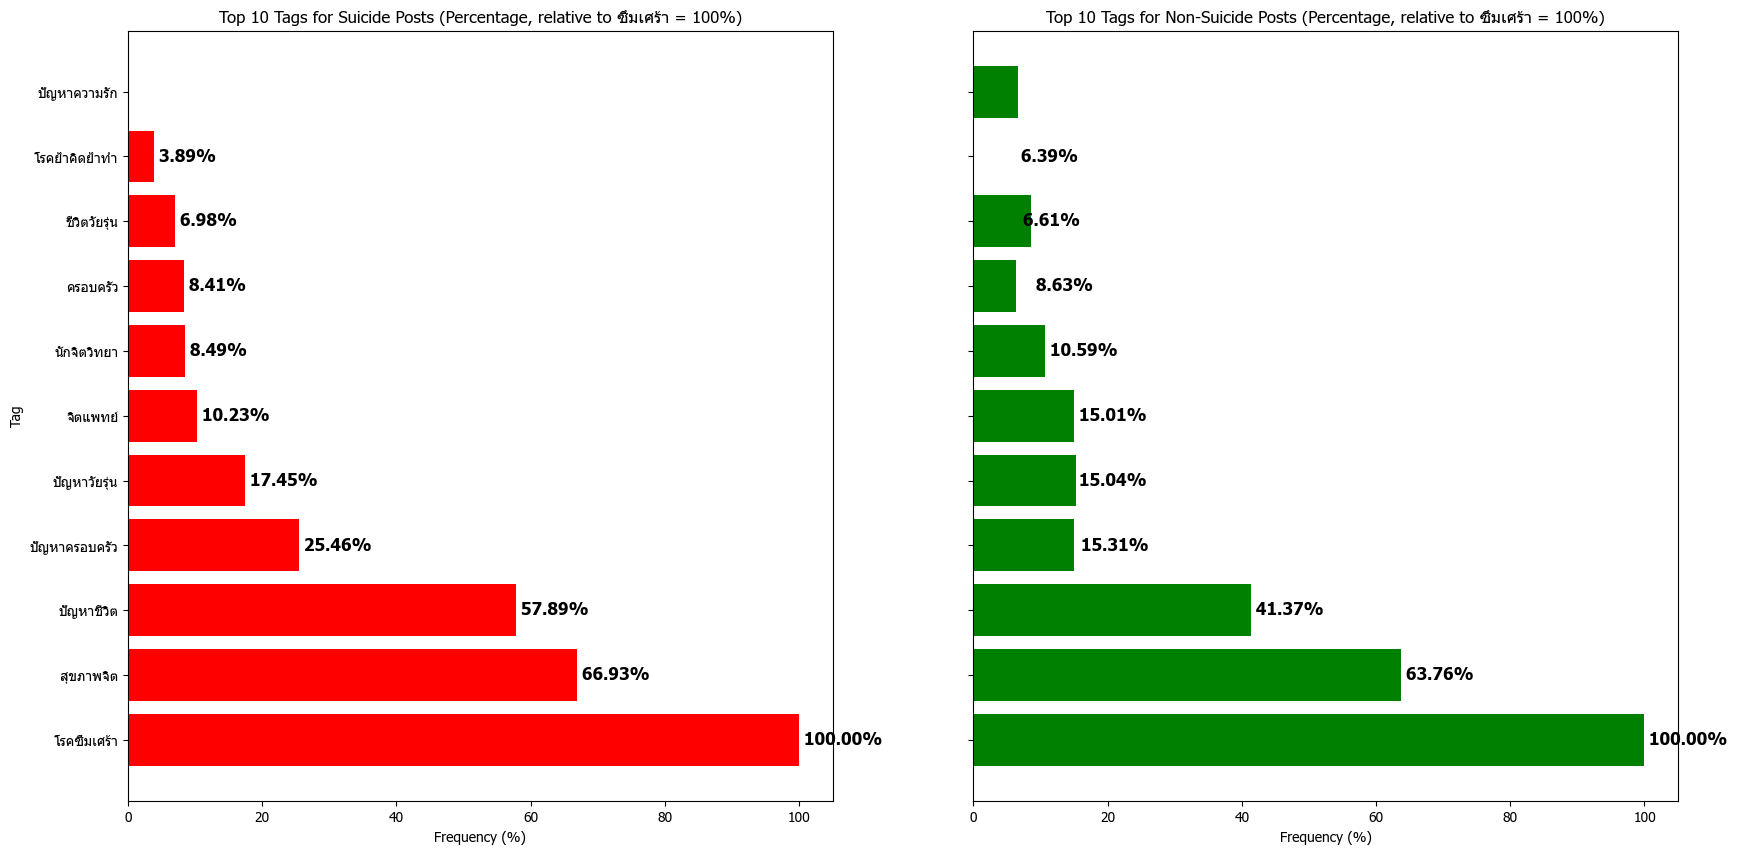

In [33]:
# Function to parse the string representation of a list
def parse_tags(tag_str):
    return ast.literal_eval(tag_str)

# Extract and flatten all tags
df_pantip_posts_suicide_labeled['parsed_tags'] = df_pantip_posts_suicide_labeled['tags'].apply(parse_tags)
all_tags = set(tag for sublist in df_pantip_posts_suicide_labeled['parsed_tags'] for tag in sublist)

# Create one-hot encoding for each tag
for tag in all_tags:
    df_pantip_posts_suicide_labeled[tag] = df_pantip_posts_suicide_labeled['parsed_tags'].apply(lambda tags: 1 if tag in tags else 0)

# Summing up the occurrences of each tag for label 1 (suicide)
tag_sums_label_1 = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1][list(all_tags)].sum().sort_values(ascending=False)

# Summing up the occurrences of each tag for label 0 (not suicide)
tag_sums_label_0 = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0][list(all_tags)].sum().sort_values(ascending=False)

# Assuming "ซึมเศร้า" is the tag to normalize to 100%
tag_depression_sum_1 = tag_sums_label_1.get("โรคซึมเศร้า", 1)  # Avoid division by zero
tag_depression_sum_0 = tag_sums_label_0.get("โรคซึมเศร้า", 1)

# Normalizing to percentages with respect to "ซึมเศร้า"
tag_sums_label_1_normalized = tag_sums_label_1 / tag_depression_sum_1 * 100
tag_sums_label_0_normalized = tag_sums_label_0 / tag_depression_sum_0 * 100

# Creating DataFrames for the top 20 tags
df_tag_sums_label_1 = pd.DataFrame({'Tag': tag_sums_label_1_normalized.index, 'Frequency (%)': tag_sums_label_1_normalized.values}).head(20)
df_tag_sums_label_0 = pd.DataFrame({'Tag': tag_sums_label_0_normalized.index, 'Frequency (%)': tag_sums_label_0_normalized.values}).head(20)

# Choose a font that supports Thai characters
matplotlib.rc('font', family='Tahoma')

# Setting up the plot for two horizontal bar charts
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Creating DataFrames for the top 10 tags instead of top 20
df_tag_sums_label_1_top10 = df_tag_sums_label_1.head(10)
df_tag_sums_label_0_top10 = df_tag_sums_label_0.head(10)

# Plotting the chart for tag_sums_label_1 (red color) with top 10 tags
axes[0].barh(df_tag_sums_label_1_top10['Tag'], df_tag_sums_label_1_top10['Frequency (%)'], color='red')
axes[0].set_title('Top 10 Tags for Suicide Posts (Percentage, relative to ซึมเศร้า = 100%)')
axes[0].set_xlabel('Frequency (%)')
axes[0].set_ylabel('Tag')

# Adding the percentage values at the end of each bar for the first chart, with larger and bolder font
for index, value in enumerate(df_tag_sums_label_1_top10['Frequency (%)']):
    axes[0].text(value, index, f' {value:.2f}%', va='center', fontsize='large', fontweight='bold')

# Plotting the chart for tag_sums_label_0 (green color) with top 10 tags
axes[1].barh(df_tag_sums_label_0_top10['Tag'], df_tag_sums_label_0_top10['Frequency (%)'], color='green')
axes[1].set_title('Top 10 Tags for Non-Suicide Posts (Percentage, relative to ซึมเศร้า = 100%)')
axes[1].set_xlabel('Frequency (%)')

# Adding the percentage values at the end of each bar for the second chart, with larger and bolder font
for index, value in enumerate(df_tag_sums_label_0_top10['Frequency (%)']):
    axes[1].text(value, index, f' {value:.2f}%', va='center', fontsize='large', fontweight='bold')

plt.show()

# **----- Do the Topical Modeling -----**

## Define data sets for topical modeling
We will to do 3 groups of topical modeling  including 

        - depression topical modeling, which use all rows of all_text column
        - suicide ideation topical modeling, which use only row label ==1 of all_text column
        - non suicide ideation topical modeling, which use only row label ==0of all_text

In [49]:
# remove keyword text from tokenized_text before LDA

# # List of strings to remove
strings_to_remove2 = ["ซึมเศร้า", "ฆ่าตัวตาย", "ตาย"]

def preprocess_and_clean_text3(tokens:list):
    return [token for token in tokens if token not in strings_to_remove2]

# Apply the function to the 'all_text' column
df_pantip_posts_suicide_labeled['tokenized_text'] = df_pantip_posts_suicide_labeled['tokenized_text'].apply(preprocess_and_clean_text3)
# Display the new 'tokenized_text' column
df_pantip_posts_suicide_labeled['tokenized_text'] 

# Define the datasets
depression_texts = df_pantip_posts_suicide_labeled['tokenized_text']
suicide_ideation_texts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 1]['tokenized_text']
non_suicide_ideation_texts = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['label'] == 0]['tokenized_text']

active_sucide_ideation_text = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['sub_label'] == 11]['tokenized_text']
passive_sucide_ideation_text = df_pantip_posts_suicide_labeled[df_pantip_posts_suicide_labeled['sub_label'] == 12]['tokenized_text']


In [39]:
depression_texts

0        [จบชีวิต, ตัวเอง, ชีวิต, ตายทั้งเป็น, โลก, กา,...
1        [ความคิด, เบื่อ, ชอบแล้ว, คนเดียว, ออกห่าง, เด...
2        [วิธี, หลุดพ้น, รัก, คบ, รัก, ใข้, ชีวิต, คบ, ...
3        [เข้าข่าย, โรค, หัว, เกริ่น, เรียน, มอ, อันดับ...
4        [เป็นโรค, รู้คิด, ร้องไห้, ครอบครัว, ดุด่า, สั...
                               ...                        
24087       [เครียด, เครียด, กินไม่ลง, จิงๆ, ทั้งวัน, หิว]
24088    [ตัวเอง, ล้มเหลว, การทำงาน, ทำงาน, บ., ชื่อเรื...
24089    [ม., เทอม, ย้ายที่, เรียน, สวัสดี, ค่า, ชื่อ, ...
24090    [อายุ, มากขึ้น, ความสุข, ชีวิต, น้อยลง, อายุ, ...
24091    [อยากรู้, คัว, ค่าย, เป็นโรค, รู้, สึก, อารมณ์...
Name: tokenized_text, Length: 23834, dtype: object

## Depression topical modeling

In [52]:
## create vocab <> ID dictionary
dictionary = Dictionary(depression_texts) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in depression_texts]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top10= [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=10)]
    print(' | '.join(top10), '\n')

---------- TOPIC 0 ----------
แม่ | พ่อ | บ้าน | เรียน | น้อง | พี่ | ทำงาน | ลูก | ด่า | แฟน 

---------- TOPIC 1 ----------
ตัวเอง | เพื่อน | ร้องไห้ | แฟน | คนเดียว | กลัว | คุย | เป็นโรค | เครียด | คนอื่น 

---------- TOPIC 2 ----------
ยา | ตัวเอง | หมอ | โรค | เป็นโรค | ชีวิต | รักษา | นอน | หาย | จิตแพทย์ 



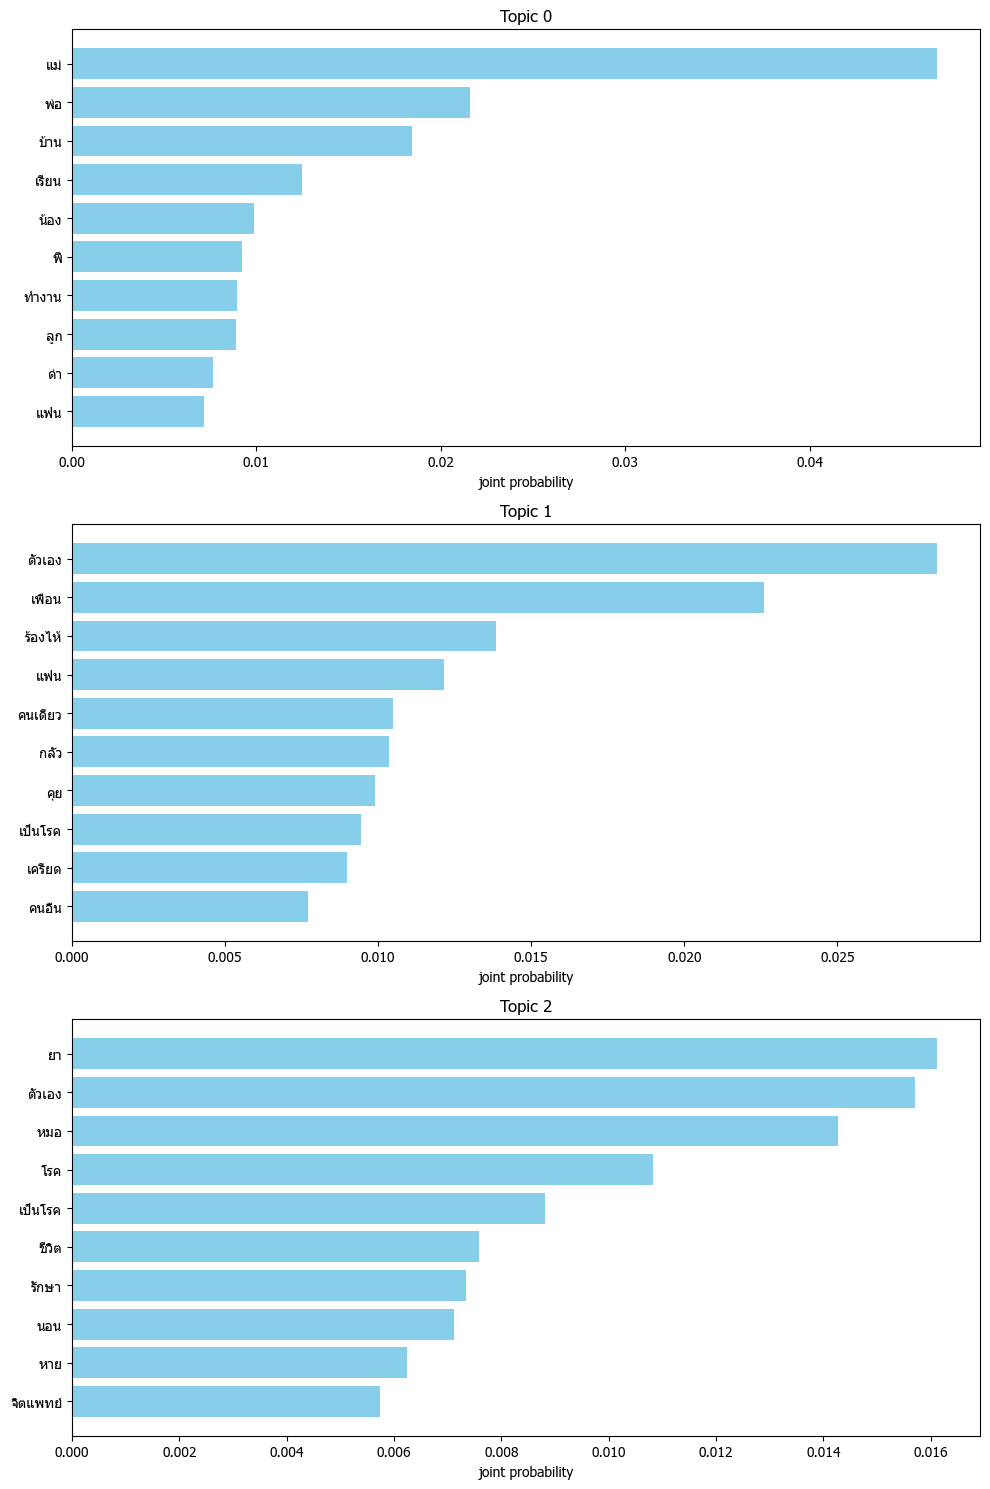

In [53]:

def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))  # Adjusting the size for 6 topics

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('joint probability')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)

## Suicide ideation topical modeling

In [54]:
## create vocab <> ID dictionary
dictionary = Dictionary(suicide_ideation_texts) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in suicide_ideation_texts]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top10 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=10)]
    print(' | '.join(top10), '\n')

---------- TOPIC 0 ----------
ตัวเอง | แม่ | เครียด | ชีวิต | หาย | เป็นโรค | เพื่อน | เหนื่อย | ครอบครัว | กลัว 

---------- TOPIC 1 ----------
แม่ | ตัวเอง | เพื่อน | เรียน | พ่อ | ชีวิต | บ้าน | ครอบครัว | ร้องไห้ | กลัว 

---------- TOPIC 2 ----------
พ่อ | เพื่อน | แม่ | บ้าน | ชีวิต | ตัวเอง | ครอบครัว | ด่า | เรียน | เครียด 



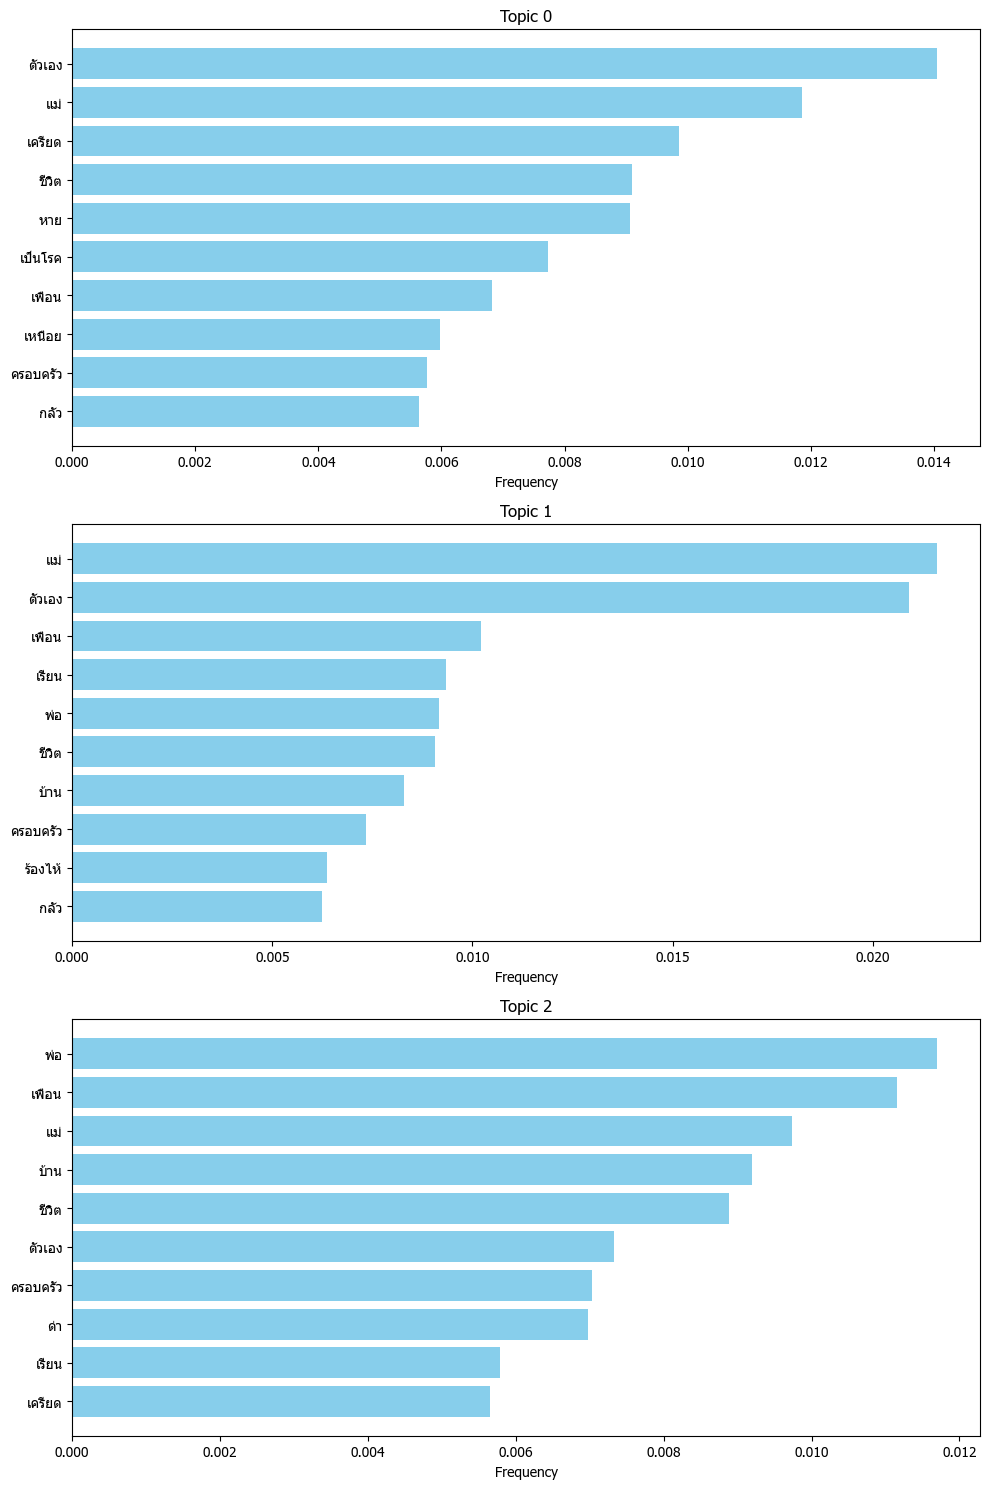

In [55]:
def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))  # Adjusting the size for 6 topics

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('Frequency')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)

## Active suicide ideation topical modeling

In [242]:
## create vocab <> ID dictionary
dictionary = Dictionary(active_sucide_ideation_text) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in active_sucide_ideation_text]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top20 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=20)]
    print(' | '.join(top20), '\n')

---------- TOPIC 0 ----------
ตัวเอง | แม่ | เพื่อน | เหนื่อย | เรียน | บ้าน | ชีวิต | นึง | พ่อ | เจอ | กลัว | พ่อแม่ | ตัว | เป็นโรค | หาย | แฟน | ครอบครัว | อายุ | ความคิด | ที่จะ 

---------- TOPIC 1 ----------
เพื่อน | แม่ | พ่อ | ตัวเอง | ชีวิต | เรียน | บ้าน | ด่า | เจอ | ครอบครัว | คนอื่น | ปัญหา | พี่ | กลัว | แฟน | หมอ | คนเดียว | ร้องไห้ | บอ | พ่อแม่ 

---------- TOPIC 2 ----------
ตัวเอง | แม่ | ครอบครัว | เครียด | พ่อ | เพื่อน | กลัว | ชีวิต | บ้าน | เรียน | ร้องไห้ | เป็นโรค | ความคิด | พ่อแม่ | คนเดียว | ที่จะ | แฟน | หา | ยา | ตอน 



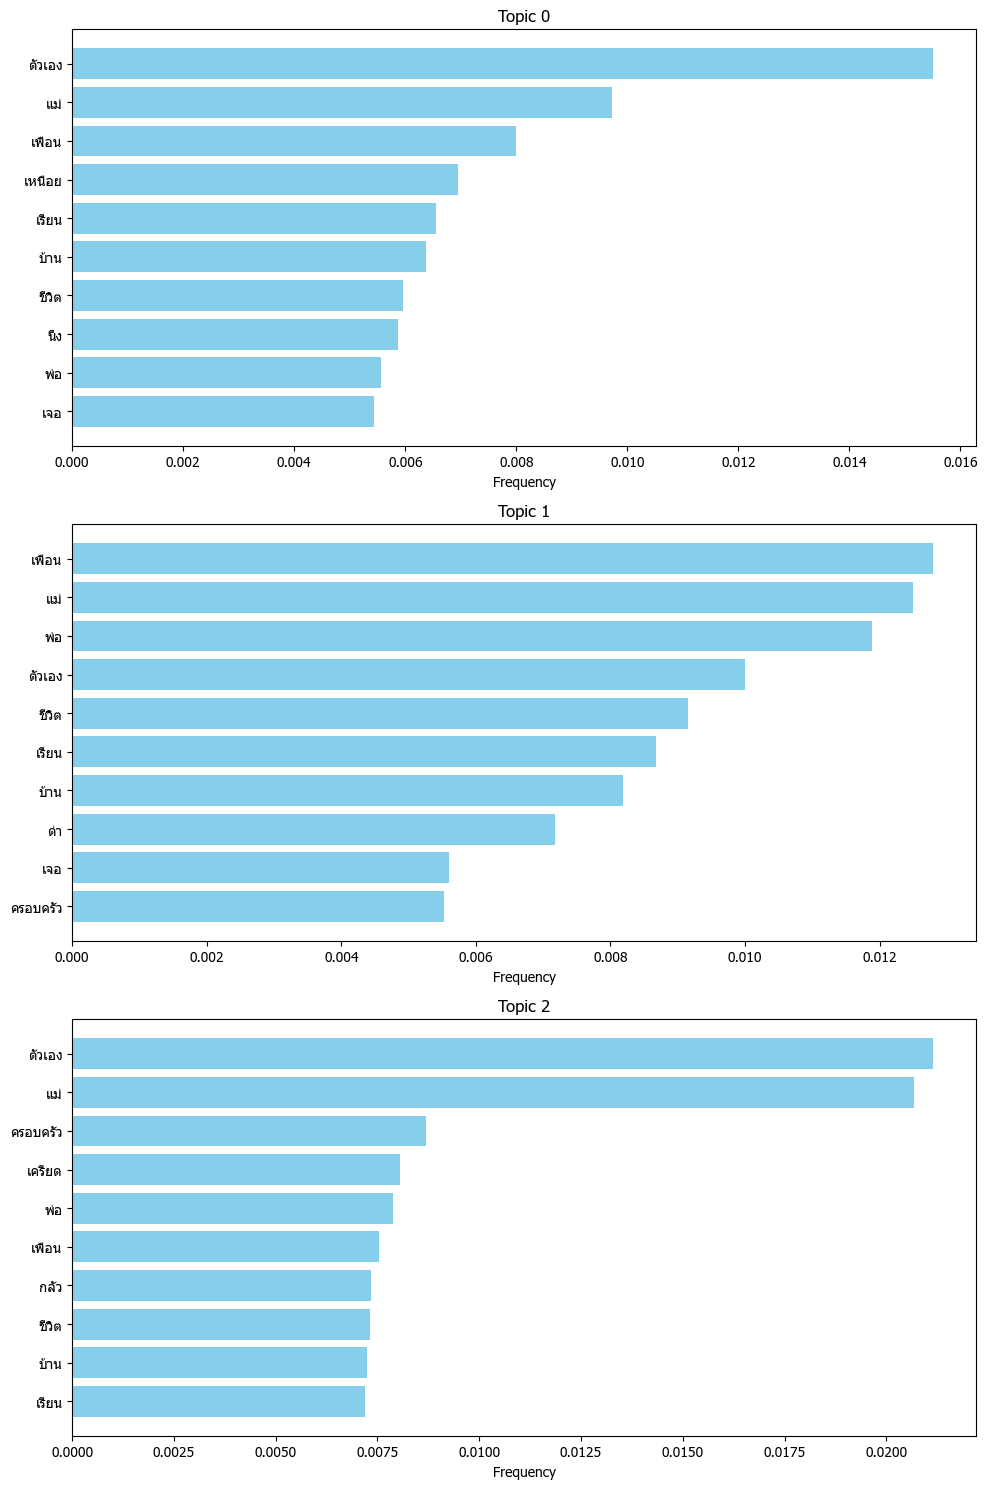

In [243]:
def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))  # Adjusting the size for 6 topics

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('Frequency')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)

## Passive suicide ideation topical modeling

In [244]:
## create vocab <> ID dictionary
dictionary = Dictionary(active_sucide_ideation_text) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in active_sucide_ideation_text]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top20 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=20)]
    print(' | '.join(top20), '\n')

---------- TOPIC 0 ----------
ตัวเอง | แม่ | พ่อ | เพื่อน | ชีวิต | บ้าน | เรียน | เป็นโรค | หมอ | ครอบครัว | หา | เหนื่อย | กลัว | ยา | เครียด | ร้องไห้ | เจอ | ด่า | คนอื่น | ตอน 

---------- TOPIC 1 ----------
แม่ | ตัวเอง | เพื่อน | ครอบครัว | เรียน | บ้าน | พ่อ | เครียด | คนเดียว | ปัญหา | ชีวิต | แฟน | ความคิด | คุย | กลัว | บอ | เหนื่อย | ร้องไห้ | เจอ | ตัว 

---------- TOPIC 2 ----------
ตัวเอง | แม่ | เพื่อน | ชีวิต | เรียน | กลัว | บ้าน | พ่อแม่ | ที่จะ | แฟน | เครียด | ครอบครัว | เจอ | ร้องไห้ | ด่า | พ่อ | ความคิด | นึง | คนเดียว | พี่ 



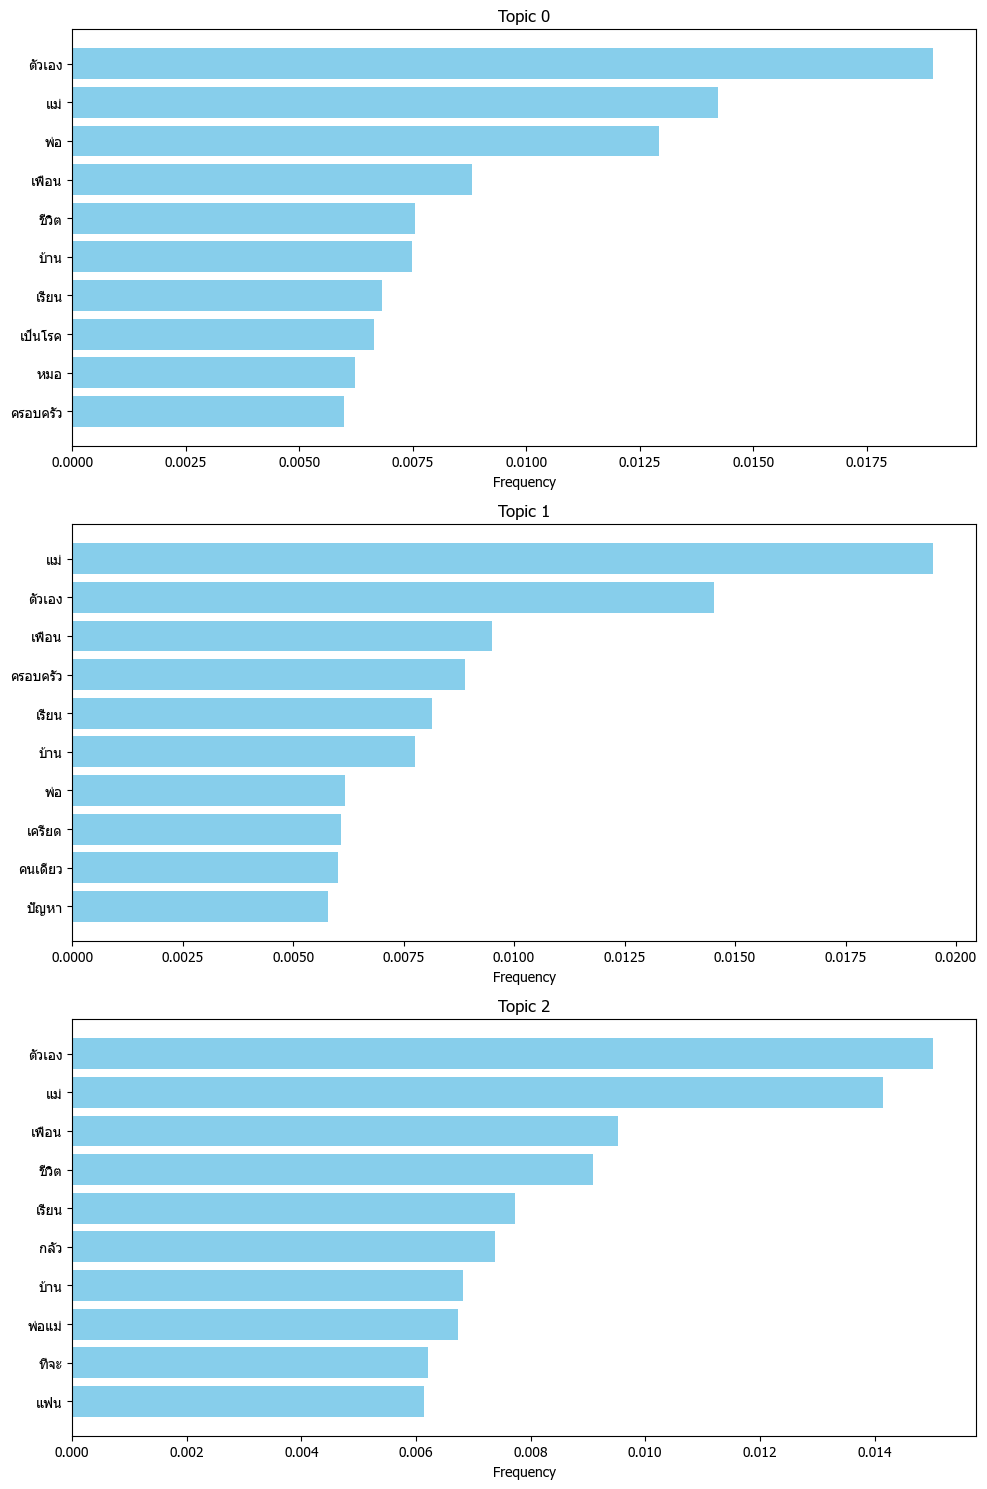

In [245]:
def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))  # Adjusting the size for 6 topics

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('Frequency')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)

## Non suicide ideation topical modeling

In [58]:
## create vocab <> ID dictionary
dictionary = Dictionary(non_suicide_ideation_texts) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in non_suicide_ideation_texts]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 10 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top20 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=10)]
    print(' | '.join(top10), '\n')

---------- TOPIC 0 ----------
พ่อ | เพื่อน | แม่ | บ้าน | ชีวิต | ตัวเอง | ครอบครัว | ด่า | เรียน | เครียด 

---------- TOPIC 1 ----------
พ่อ | เพื่อน | แม่ | บ้าน | ชีวิต | ตัวเอง | ครอบครัว | ด่า | เรียน | เครียด 

---------- TOPIC 2 ----------
พ่อ | เพื่อน | แม่ | บ้าน | ชีวิต | ตัวเอง | ครอบครัว | ด่า | เรียน | เครียด 



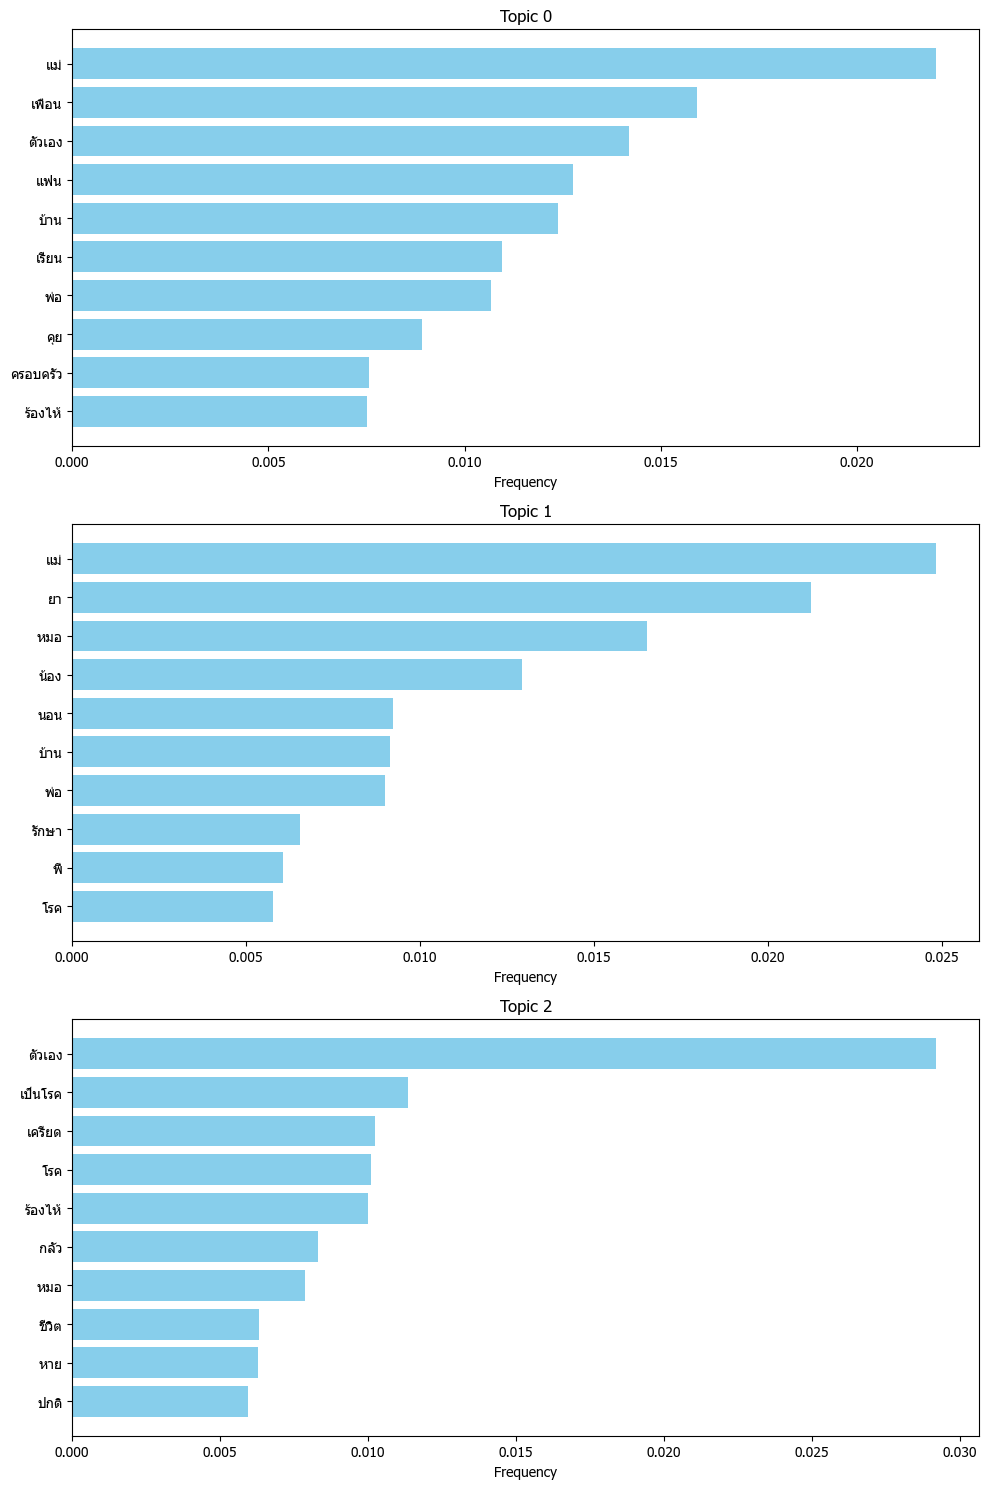

In [59]:
def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))  # Adjusting the size for 6 topics

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('Frequency')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)